# 药物/化合物毒性风险建模与网络医学机制解析（端到端 Notebook）

本 Notebook 以两份本地输入表为起点，构建从“结构表征 → 毒性/ADR 先验 → 药物-靶点作用预测 → 网络传播 → 通路解释”的完整分析流程。主要目的包括：

1. **毒性风险建模**：利用 ToxCast（弱监督 hazard）、ClinTox（临床毒性）与 SIDER（ADR 表型）等公开数据训练结构模型，并将预测概率投影到你的化合物列表，形成多源毒性先验；
2. **药物–靶点–通路整合**：基于 ChEMBL 构建可靠监督的 DTI 数据集（SMILES + 蛋白序列），预测化合物-靶点相互作用并与疾病相关性权重融合，生成候选作用对及综合评分；
3. **机制与生物标志物线索**：在 STRING PPI 子网上对高风险化合物进行 Random Walk with Restart 扩散，量化疾病模块扰动，并输出候选机制基因与 Reactome 通路层解释。

输入：
- `Chemical List tox21sl-2026-01-12.csv`：化合物清单（含 SMILES 与 ToxCast 活性比例等字段）
- `GeneCards-SearchResults.csv`：疾病相关基因清单（含 Relevance score 与 UniProt 标识等字段）

输出：
- 结果文件写入 `outputs/`；外部数据与中间缓存写入 `data_external/`，以便重复运行与结果复用。


In [1]:
# 本单元格功能与目的：
# - 导入本分析所需的第三方依赖与项目内部模块（`src/jtm_risk`）。
# - 设置随机种子、绘图风格与告警过滤，保证结果展示一致且便于复现。
# - 定义输入/输出/缓存路径与关键超参数（建模阈值、特征维度、网络传播参数等），作为后续各步骤的统一配置入口。

from __future__ import annotations

import json
import warnings
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

sns.set_theme(style="whitegrid", context="talk")
np.random.seed(42)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- project root & imports ---
CWD = Path.cwd().resolve()


def _find_project_root(start: Path) -> Path:
    """Resolve project root robustly for different launch directories.

    Priority:
    1) current directory contains `src/`
    2) parent directory contains `src/`
    3) one-level child directory contains `src/` (common when launching Jupyter from an outer workspace)
    """

    candidates = [start, start.parent]
    for p in candidates:
        if (p / "src").exists():
            return p

    try:
        for child in start.iterdir():
            if child.is_dir() and (child / "src").exists():
                return child
    except Exception:
        pass

    return start


PROJECT_ROOT = _find_project_root(CWD).resolve()
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from jtm_risk.io import (
    ensure_unique_uniprot_ids,
    load_chemical_list,
    load_genecards_targets,
    select_top_targets,
)
from jtm_risk.datasets import load_molnet_clintox, load_molnet_sider
from jtm_risk.external import (
    chembl_build_training_activities,
    uniprot_get_sequences,
    uniprot_map_gene_symbols_to_accessions,
)
from jtm_risk.integration import compute_pair_impact_score, compute_toxicity_prior
from jtm_risk.modeling import (
    build_dti_dataset_from_chembl,
    fit_dti_model_full,
    fit_hazard_model_full,
    fit_smiles_binary_model_full,
    fit_smiles_multilabel_model_full,
    score_chemical_target_pairs,
    train_dti_model,
    train_dti_model_random_split,
    train_hazard_model,
    train_smiles_binary_model,
    train_smiles_multilabel_model,
)
from jtm_risk.network import (
    build_ppi_index,
    random_walk_with_restart,
    string_build_ppi_cache,
)
from jtm_risk.reactome import reactome_build_mapping

# --- paths ---
CHEM_CSV = PROJECT_ROOT / "Chemical List tox21sl-2026-01-12.csv"
GENE_CSV = PROJECT_ROOT / "GeneCards-SearchResults.csv"
REQUIRED_PAIRS_CSV = PROJECT_ROOT / "required_pairs.csv"
CACHE_DIR = PROJECT_ROOT / "data_external"
OUT_DIR = PROJECT_ROOT / "outputs"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = OUT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- knobs (建议先小规模跑通，再调大) ---
TOP_N_TARGETS_FOR_DOWNLOAD = 120
MAX_CHEMBL_TARGETS_FOR_TRAINING = 50
MAX_ACTIVITIES_PER_TARGET = 4000

TOP_K_CHEMICALS_FOR_SCORING = 200
TOP_K_TARGETS_FOR_SCORING = 300

HAZARD_THRESHOLD_ACTIVE_PCT = 10.0
DTI_ACTIVE_NM = 1000.0
DTI_INACTIVE_NM = 10000.0

MAX_FEATURES = 120_000
DTI_SVD_COMPONENTS = 128
DTI_NEG_SAMPLE_RATIO = 1.0

# Network medicine knobs
STRING_REQUIRED_SCORE = 700
STRING_ADD_NODES = 150
RWR_RESTART = 0.5
TOP_SEED_TARGETS_PER_CHEM = 25
TOP_CHEMICALS_FOR_NETWORK = 30


# --- persist run config (for reporting/reproducibility) ---
RUN_CONFIG = {
    "cwd": str(CWD),
    "project_root": str(PROJECT_ROOT),
    "inputs": {
        "chemical_csv": str(CHEM_CSV),
        "gene_csv": str(GENE_CSV),
        "required_pairs_csv": str(REQUIRED_PAIRS_CSV),
    },
    "paths": {
        "cache_dir": str(CACHE_DIR),
        "out_dir": str(OUT_DIR),
        "model_dir": str(MODEL_DIR),
    },
    "parameters": {
        "TOP_N_TARGETS_FOR_DOWNLOAD": TOP_N_TARGETS_FOR_DOWNLOAD,
        "MAX_CHEMBL_TARGETS_FOR_TRAINING": MAX_CHEMBL_TARGETS_FOR_TRAINING,
        "MAX_ACTIVITIES_PER_TARGET": MAX_ACTIVITIES_PER_TARGET,
        "TOP_K_CHEMICALS_FOR_SCORING": TOP_K_CHEMICALS_FOR_SCORING,
        "TOP_K_TARGETS_FOR_SCORING": TOP_K_TARGETS_FOR_SCORING,
        "HAZARD_THRESHOLD_ACTIVE_PCT": HAZARD_THRESHOLD_ACTIVE_PCT,
        "DTI_ACTIVE_NM": DTI_ACTIVE_NM,
        "DTI_INACTIVE_NM": DTI_INACTIVE_NM,
        "MAX_FEATURES": MAX_FEATURES,
        "DTI_SVD_COMPONENTS": DTI_SVD_COMPONENTS,
        "DTI_NEG_SAMPLE_RATIO": DTI_NEG_SAMPLE_RATIO,
        "STRING_REQUIRED_SCORE": STRING_REQUIRED_SCORE,
        "STRING_ADD_NODES": STRING_ADD_NODES,
        "RWR_RESTART": RWR_RESTART,
        "TOP_SEED_TARGETS_PER_CHEM": TOP_SEED_TARGETS_PER_CHEM,
        "TOP_CHEMICALS_FOR_NETWORK": TOP_CHEMICALS_FOR_NETWORK,
    },
}
(OUT_DIR / "run_config.json").write_text(
    json.dumps(RUN_CONFIG, ensure_ascii=False, indent=2),
    encoding="utf-8",
)
print("saved run config ->", OUT_DIR / "run_config.json")


saved run config -> /media/xuchengjie/E7562A2674DB25F7/Practices/JTM_1.13/JTM_1.13/outputs/run_config.json


## 1) 输入数据读取与基础质控

本单元格用于加载两份本地输入表，并对后续流程依赖的关键字段进行可用性检查与分布概览，从而确认可建模样本规模与权重信号的范围。下方将输出：

- 化合物 `smiles` 缺失情况（决定可进入结构模型的样本数量）
- `% ToxCast Active` 的分布（用于构建 hazard 弱监督风险标签）
- GeneCards `Relevance score` 的分布（用于疾病模块/通路加权与网络传播的先验权重）


required pairs loaded: 1


,dtxsid,preferred_name,casrn,inchikey,iupac_name,smiles,inchi_string,molecular_formula,average_mass,monoisotopic_mass,qc_level,toxcast_active_count,total_assays,toxcast_active_pct,dtxsid_url,toxcast_active_count_raw
0,DTXSID0020020,Actarit,18699-02-0,MROJXXOCABQVEF-UHFFFAOYSA-N,(4-Acetamidophenyl)acetic acid,CC(=O)NC1=CC=C(CC(O)=O)C=C1,InChI=1S/C10H11NO3/c1-7(12)11-9-4-2-8(3-5-9)6-...,C10H11NO3,193.202,193.073893,1,0,326,0,https://comptox.epa.gov/dashboard/chemical/det...,0/326
1,DTXSID0020022,Acifluorfen,50594-66-6,NUFNQYOELLVIPL-UHFFFAOYSA-N,5-[2-Chloro-4-(trifluoromethyl)phenoxy]-2-nitr...,OC(=O)C1=C(C=CC(OC2=CC=C(C=C2Cl)C(F)(F)F)=C1)[...,"InChI=1S/C14H7ClF3NO5/c15-10-5-7(14(16,17)18)1...",C14H7ClF3NO5,361.660,360.996485,1,49,692,7,https://comptox.epa.gov/dashboard/chemical/det...,49/692
2,DTXSID0020024,Acrolein diethylacetal,3054-95-3,MCIPQLOKVXSHTD-UHFFFAOYSA-N,"3,3-Diethoxyprop-1-ene",CCOC(OCC)C=C,"InChI=1S/C7H14O2/c1-4-7(8-5-2)9-6-3/h4,7H,1,5-...",C7H14O2,130.187,130.099380,1,0,244,0,https://comptox.epa.gov/dashboard/chemical/det...,0/244
3,DTXSID0020070,Aminocaproic acid,60-32-2,SLXKOJJOQWFEFD-UHFFFAOYSA-N,6-Aminohexanoic acid,NCCCCCC(O)=O,"InChI=1S/C6H13NO2/c7-5-3-1-2-4-6(8)9/h1-5,7H2,...",C6H13NO2,131.175,131.094629,1,3,244,1,https://comptox.epa.gov/dashboard/chemical/det...,3/244
4,DTXSID0020072,4-Biphenylamine hydrochloride,2113-61-3,GUHXYHYUBFCYGJ-UHFFFAOYSA-N,"[1,1'-Biphenyl]-4-amine--hydrogen chloride (1/1)",Cl.NC1=CC=C(C=C1)C1=CC=CC=C1,InChI=1S/C12H11N.ClH/c13-12-8-6-11(7-9-12)10-4...,C12H12ClN,205.690,205.065827,1,27,338,8,https://comptox.epa.gov/dashboard/chemical/det...,27/338


,gene_symbol,description,uniprot_id,gifts,gc_id,relevance_score
0,BRCA2,BRCA2 DNA Repair Associated,P51587,60,GC13P032315,361.377869
1,EGFR,Epidermal Growth Factor Receptor,P00533,67,GC07P055019,345.411072
2,BRCA1,BRCA1 DNA Repair Associated,P38398,63,GC17M043044,345.269898
3,ATM,ATM Serine/Threonine Kinase,Q13315,66,GC11P108222,295.993988
4,TP53,Tumor Protein P53,P04637,66,GC17M007661,264.356018


chem shape: (8947, 16)
genes shape: (20595, 6)
chem smiles missing: 317
genes uniprot missing: 1295


/tmp/ipykernel_491308/3025879818.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index, y=missing.values, ax=axes[1], palette="viridis")


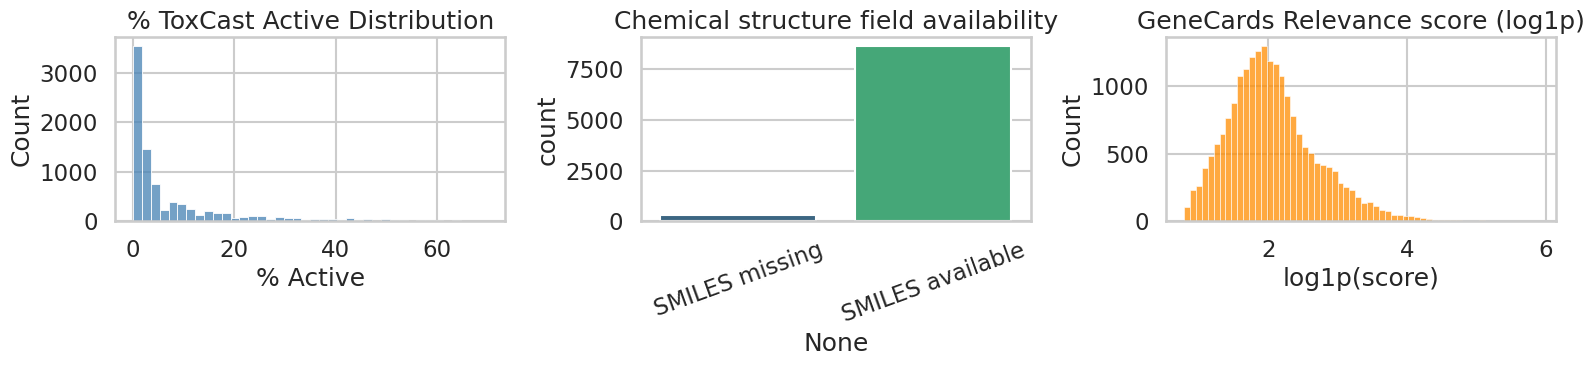

In [2]:
# 本单元格功能与目的：
# - 读取化合物列表与 GeneCards 靶点表，展示样例以核对字段解析是否正确。
# - 统计关键缺失值与样本量，并绘制质控图（ToxCast 活性比例、SMILES 可用性、Relevance score 分布）。
# - 目的：在进入模型训练前确认输入数据质量，并为阈值/权重设置提供依据。

chem = load_chemical_list(CHEM_CSV)
genes = load_genecards_targets(GENE_CSV)

# Optional: required chemical-target pairs (coverage constraints)
# If `required_pairs.csv` exists, downstream scoring will ensure these pairs are included.
REQUIRED_PAIRS = pd.DataFrame(columns=["dtxsid","gene_symbol"])
if REQUIRED_PAIRS_CSV.exists():
    _rp = pd.read_csv(REQUIRED_PAIRS_CSV)
    _rp.columns = [str(c).strip().lower() for c in _rp.columns]
    if not {"dtxsid","gene_symbol"}.issubset(set(_rp.columns)):
        raise ValueError("required_pairs.csv must contain columns: dtxsid, gene_symbol")
    _rp = _rp[["dtxsid","gene_symbol"]].copy()
    _rp["dtxsid"] = _rp["dtxsid"].astype(str).str.strip().str.extract(r"(DTXSID\d+)", expand=False)
    _rp["gene_symbol"] = _rp["gene_symbol"].astype(str).str.strip().str.upper()
    _rp = _rp.dropna(subset=["dtxsid","gene_symbol"]).drop_duplicates().reset_index(drop=True)
    REQUIRED_PAIRS = _rp

REQUIRED_DTXSIDS = set(REQUIRED_PAIRS["dtxsid"].astype(str).tolist())
REQUIRED_GENE_SYMBOLS = set(REQUIRED_PAIRS["gene_symbol"].astype(str).tolist())

_gene_to_uni = (
    genes.dropna(subset=["gene_symbol","uniprot_id"])
    .assign(gene_symbol_norm=lambda d: d["gene_symbol"].astype(str).str.strip().str.upper())
    .groupby("gene_symbol_norm", as_index=True)["uniprot_id"].first()
    .to_dict()
)
REQUIRED_UNIPROT_IDS = sorted({str(_gene_to_uni[g]).strip() for g in REQUIRED_GENE_SYMBOLS if g in _gene_to_uni and str(_gene_to_uni[g]).strip()})

_missing_req = [g for g in REQUIRED_GENE_SYMBOLS if g not in _gene_to_uni]
if _missing_req:
    raise ValueError(f"Some required gene symbols cannot be mapped to UniProt IDs: {len(_missing_req)}")

print("required pairs loaded:", len(REQUIRED_PAIRS))

display(chem.head())
display(genes.head())

print("chem shape:", chem.shape)
print("genes shape:", genes.shape)
print("chem smiles missing:", chem["smiles"].isna().sum())
print("genes uniprot missing:", genes["uniprot_id"].isna().sum())

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(chem["toxcast_active_pct"].dropna(), bins=40, ax=axes[0], color="steelblue")
axes[0].set_title("% ToxCast Active Distribution")
axes[0].set_xlabel("% Active")

missing = pd.Series({"SMILES missing": int(chem["smiles"].isna().sum()), "SMILES available": int(chem["smiles"].notna().sum())})
sns.barplot(x=missing.index, y=missing.values, ax=axes[1], palette="viridis")
axes[1].set_title("Chemical structure field availability")
axes[1].set_ylabel("count")
axes[1].tick_params(axis='x', rotation=20)

sns.histplot(np.log1p(genes["relevance_score"].dropna()), bins=60, ax=axes[2], color="darkorange")
axes[2].set_title("GeneCards Relevance score (log1p)")
axes[2].set_xlabel("log1p(score)")

plt.tight_layout()
plt.show()


**图示解读与用途**：

- 左图：`toxcast_active_pct` 的分布通常呈偏态，用于评估弱监督 hazard 标签的可分性，并辅助选择 `HAZARD_THRESHOLD_ACTIVE_PCT` 等阈值；
- 中图：SMILES 缺失与可用样本量对比，用于评估结构建模覆盖率以及后续候选对数量上限；
- 右图：GeneCards 相关性权重的尺度（此处用 `log1p` 展示），用于理解疾病模块权重的长尾特征，并作为网络/通路聚合时的权重输入。


## 2) 外部训练数据获取与缓存（可复现）

本单元格用于下载并缓存 MoleculeNet 数据集，使结构模型不仅覆盖体外活性信号（ToxCast），也能学习更接近临床与表型层面的毒性信息。数据会保存到 `data_external/`，重复运行将直接复用缓存以保证一致性。

- **ClinTox**：二分类临床毒性标签（`CT_TOX`），用于训练结构→临床毒性概率模型；
- **SIDER**：多标签 ADR 系统器官类别（27 个标签），用于训练结构→不良反应表型的多标签模型。


ClinTox: (1484, 3)
SIDER: (1427, 28)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


,smiles,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,...,"Congenital, familial and genetic disorders",Infections and infestations,"Respiratory, thoracic and mediastinal disorders",Psychiatric disorders,Renal and urinary disorders,"Pregnancy, puerperium and perinatal conditions",Ear and labyrinth disorders,Cardiac disorders,Nervous system disorders,"Injury, poisoning and procedural complications"
0,C(CNCCNCCNCCN)N,1,1,0,0,1,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1,CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=...,0,1,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,1,0
2,CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O...,0,1,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,CCC12CC(=C)C3C(C1CC[C@]2(C#C)O)CCC4=CC(=O)CCC34,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0,1,1
4,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,1,1,0,1,1,1,1,0,1,...,0,1,1,1,0,0,1,0,1,0


/tmp/ipykernel_491308/4184768754.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prevalence.head(10).values, y=prevalence.head(10).index, ax=axes[1], palette="magma")


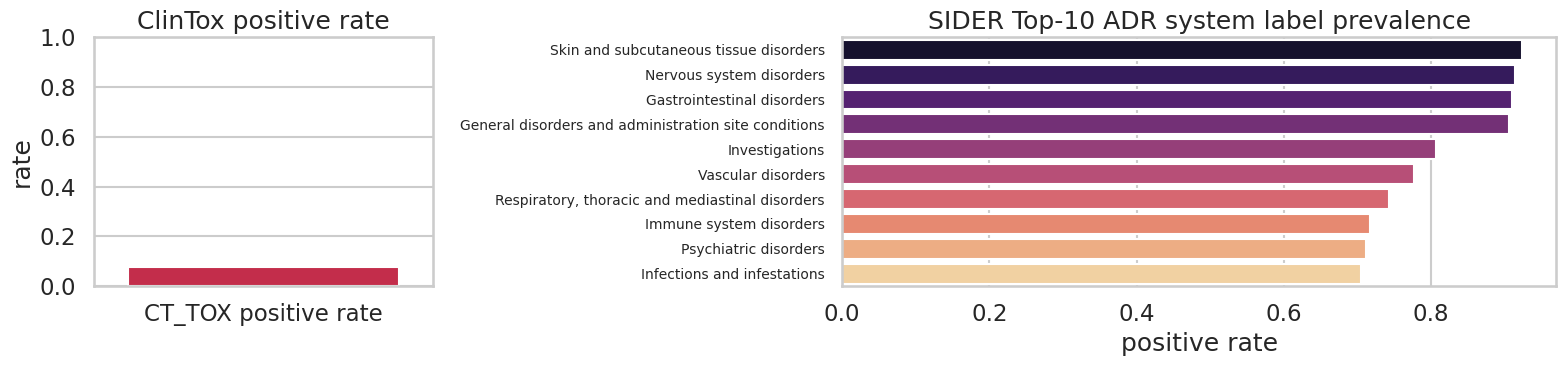

In [3]:
# 本单元格功能与目的：
# - 下载并读取 MoleculeNet 的 ClinTox 与 SIDER 数据集（使用本地缓存以保证可复现）。
# - 输出数据规模与字段预览，并可视化 ClinTox 正例比例与 SIDER 各标签流行率，便于理解类别不平衡程度。
# - 这些统计将用于后续选择合适的训练/评估策略（如校准、多标签评估）。

clintox = load_molnet_clintox(cache_dir=CACHE_DIR)
sider = load_molnet_sider(cache_dir=CACHE_DIR)

print("ClinTox:", clintox.shape)
print("SIDER:", sider.shape)
display(clintox.head())
display(sider.head())

fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={"width_ratios": [1.0, 2.1]})
ct_pos = clintox["CT_TOX"].mean()
sns.barplot(x=["CT_TOX positive rate"], y=[ct_pos], ax=axes[0], color="crimson")
axes[0].set_ylim(0, 1)
axes[0].set_title("ClinTox positive rate")
axes[0].set_ylabel("rate")

label_cols = [c for c in sider.columns if c != "smiles"]
prevalence = sider[label_cols].mean().sort_values(ascending=False)
sns.barplot(x=prevalence.head(10).values, y=prevalence.head(10).index, ax=axes[1], palette="magma")
axes[1].set_title("SIDER Top-10 ADR system label prevalence")
axes[1].set_xlabel("positive rate")
axes[1].set_ylabel("")
axes[1].tick_params(axis="y", labelsize=10)

plt.tight_layout()
plt.show()


**数据分布解读与建模含义**：

- ClinTox 的正例比例通常极低，属于典型类别不平衡任务；评估时更适合关注 PR-AUC 等对正例更敏感的指标；
- SIDER 不同系统 ADR 的流行率差异显著，因此后续采用 One-vs-Rest 的多标签策略，并同时给出总体与逐标签的性能概览，便于识别“可预测”与“难预测”的表型类别。


## 3) 训练“毒性先验”模型（结构 → 风险/表型）

本单元格用于说明将要训练的三类结构模型及其在后续整合中的作用。每个模型都会输出评估指标，并把预测概率投影到你的化合物列表，形成可直接用于排序与融合的先验特征：

- **Hazard（ToxCast 弱监督）**：以 `%ToxCastActive >= 阈值` 构造弱监督标签，得到广谱活性驱动的风险概率；
- **ClinTox（`CT_TOX`）**：学习结构与临床毒性标签的关联，得到临床相关的风险先验；
- **SIDER（27 个 ADR 标签）**：学习结构到系统器官不良反应表型的多标签映射，提供表型维度的先验信息（后续示例将选取免疫系统 ADR 概率参与融合）。


Hazard metrics: {
  "roc_auc": 0.8534785307615986,
  "pr_auc": 0.6720993699696045,
  "accuracy": 0.7711471610660486,
  "f1": 0.639269406392694
}


,preferred_name,toxcast_active_pct,hazard_prob
2727,"N,N'-Di-2-naphthyl-p-phenylenediamine",5,0.967374
3935,Difethialone,28,0.962871
4864,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",63,0.962516
2144,D&C Red 27,49,0.961348
4578,"Bis(4-hydroxyphenyl)-2,2-dichloroethylene",28,0.957262
6498,C.I. Solvent Red 72,27,0.956647
405,Fluorescein,16,0.954380
1260,Temephos,27,0.953680
3690,Fulvestrant,21,0.951821
3338,Lumefantrine,22,0.951725


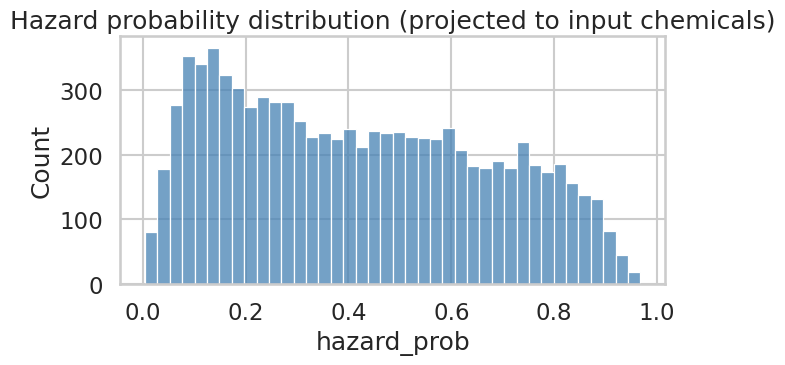

In [4]:
# 本单元格功能与目的：
# - 基于 `toxcast_active_pct` 构造弱监督 hazard 标签，训练并评估结构→风险的二分类模型。
# - 在全量数据上拟合最终 hazard 模型，并将 hazard 概率投影到本地化合物列表，形成 `hazard_prob` 特征。
# - 可视化风险概率分布，并将模型保存到 `outputs/models/` 以便后续复用。

haz_eval, haz_metrics = train_hazard_model(
    chem,
    threshold_active_pct=HAZARD_THRESHOLD_ACTIVE_PCT,
    max_features=MAX_FEATURES,
)
print("Hazard metrics:", json.dumps(haz_metrics, indent=2, ensure_ascii=False))

# Train full hazard model for downstream use
haz_model = fit_hazard_model_full(
    chem,
    threshold_active_pct=HAZARD_THRESHOLD_ACTIVE_PCT,
    max_features=MAX_FEATURES,
)
joblib.dump(haz_model, MODEL_DIR / "hazard_model.joblib")

# Build chemical table for downstream modeling
chem2 = chem.dropna(subset=["smiles"]).copy()
chem2["hazard_prob"] = haz_model.predict_proba(chem2["smiles"].astype(str).tolist())

display(chem2.sort_values("hazard_prob", ascending=False).head(10)[["preferred_name","toxcast_active_pct","hazard_prob"]])

plt.figure(figsize=(7, 4))
sns.histplot(chem2["hazard_prob"], bins=40, color="steelblue")
plt.title("Hazard probability distribution (projected to input chemicals)")
plt.xlabel("hazard_prob")
plt.tight_layout()
plt.show()


ClinTox metrics: {
  "roc_auc": 0.9950413223140495,
  "pr_auc": 0.958133971291866,
  "accuracy": 0.98989898989899,
  "f1": 0.926829268292683,
  "positives": 112.0,
  "samples": 1484.0
}


,preferred_name,hazard_prob,clintox_prob
7351,Telmisartan,0.851955,0.999779
5177,SSR161421,0.881955,0.999749
4864,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",0.962516,0.999670
7010,Naphthalen-2-yl 2-aminobenzoate,0.886100,0.999550
7644,C.I. Solvent Red 24,0.916136,0.999523
8878,"Dibenz[a,c]anthracene",0.903912,0.999515
2727,"N,N'-Di-2-naphthyl-p-phenylenediamine",0.967374,0.999423
311,4-(2-Phenylpropan-2-yl)-N-[4-(2-phenylpropan-2...,0.941818,0.999413
5746,Boscalid,0.852833,0.999377
6514,"4,4'-Diphenylmethane diisocyanate",0.730299,0.999361


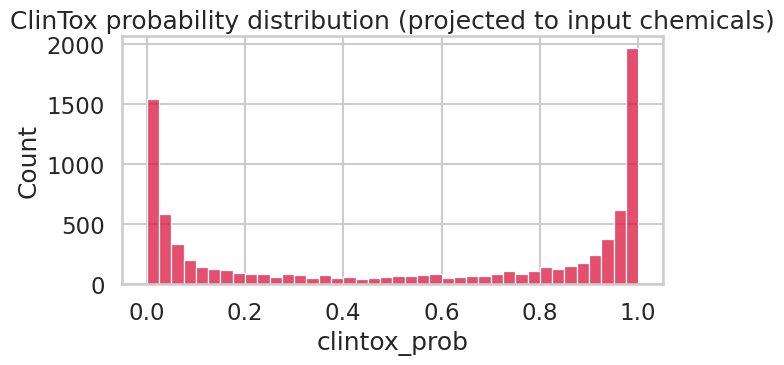

In [5]:
# 本单元格功能与目的：
# - 使用 MoleculeNet ClinTox（`CT_TOX`）训练结构→临床毒性概率模型，并输出评估指标（含校准）。
# - 在全量数据上拟合最终模型，将预测概率写回 `chem2` 的 `clintox_prob` 列，供后续融合与排序。
# - 可视化分布并保存模型到 `outputs/models/`，以便与其他先验联合使用。

clintox_eval, clintox_metrics = train_smiles_binary_model(
    clintox,
    smiles_col="smiles",
    label_col="CT_TOX",
    label_name="ClinTox_CT_TOX",
    max_features=MAX_FEATURES,
    calibrate=True,
)
print("ClinTox metrics:", json.dumps(clintox_metrics, indent=2, ensure_ascii=False))

clintox_model = fit_smiles_binary_model_full(
    clintox,
    smiles_col="smiles",
    label_col="CT_TOX",
    label_name="ClinTox_CT_TOX",
    max_features=MAX_FEATURES,
    calibrate=True,
)
joblib.dump(clintox_model, MODEL_DIR / "clintox_model.joblib")
chem2["clintox_prob"] = clintox_model.predict_proba(chem2["smiles"].astype(str).tolist())

display(chem2.sort_values("clintox_prob", ascending=False).head(10)[["preferred_name","hazard_prob","clintox_prob"]])

plt.figure(figsize=(7, 4))
sns.histplot(chem2["clintox_prob"], bins=40, color="crimson")
plt.title("ClinTox probability distribution (projected to input chemicals)")
plt.xlabel("clintox_prob")
plt.tight_layout()
plt.show()


In [6]:
# 本单元格功能与目的：
# - 使用 MoleculeNet SIDER 的多标签 ADR 数据训练结构→表型概率模型（27 标签）。
# - 输出整体与逐标签评估结果，并在全量数据上拟合最终模型供下游投影。
# - 将 ADR 概率合并到 `chem2`（列名前缀 `adr_prob::`），并保存模型到 `outputs/models/`。

sider_label_cols = [c for c in sider.columns if c != "smiles"]

sider_eval, sider_metrics, sider_per_label = train_smiles_multilabel_model(
    sider,
    smiles_col="smiles",
    label_cols=sider_label_cols,
    max_features=MAX_FEATURES,
)
print("SIDER metrics:", json.dumps(sider_metrics, indent=2, ensure_ascii=False))
display(sider_per_label.head(10))

sider_model = fit_smiles_multilabel_model_full(
    sider,
    smiles_col="smiles",
    label_cols=sider_label_cols,
    max_features=MAX_FEATURES,
)
joblib.dump(sider_model, MODEL_DIR / "sider_model.joblib")
sider_probs = sider_model.predict_proba_df(chem2["smiles"].astype(str).tolist())
sider_probs.columns = [f"adr_prob::{c}" for c in sider_probs.columns]
chem2 = pd.concat([chem2.reset_index(drop=True), sider_probs.reset_index(drop=True)], axis=1)

immune_col = "adr_prob::Immune system disorders"
hepato_col = "adr_prob::Hepatobiliary disorders"
cardiac_col = "adr_prob::Cardiac disorders"

display(
    chem2.sort_values(immune_col, ascending=False)
    .head(10)[["preferred_name","hazard_prob","clintox_prob",immune_col,hepato_col,cardiac_col]]
)


SIDER metrics: {
  "samples": 1427.0,
  "n_labels": 27.0,
  "micro_pr_auc": 0.7814732722814389
}


,label,roc_auc,pr_auc,positives
0,Cardiac disorders,0.761566,0.859752,199
1,Eye disorders,0.722753,0.810230,169
2,"Neoplasms benign, malignant and unspecified (i...",0.715031,0.549470,77
3,Blood and lymphatic system disorders,0.701663,0.778493,174
4,Musculoskeletal and connective tissue disorders,0.698917,0.829744,201
5,Hepatobiliary disorders,0.696276,0.683794,147
6,Investigations,0.696234,0.879558,228
7,Nervous system disorders,0.692293,0.967367,267
8,"Respiratory, thoracic and mediastinal disorders",0.687103,0.859750,217
9,Reproductive system and breast disorders,0.680598,0.711796,151


,preferred_name,hazard_prob,clintox_prob,adr_prob::Immune system disorders,adr_prob::Hepatobiliary disorders,adr_prob::Cardiac disorders
1003,Cefpodoxime proxetil,0.373804,0.302794,0.848220,0.696915,0.540670
4022,Edoxudine,0.185160,0.280792,0.822609,0.636628,0.539427
1004,Cefroxadine,0.225853,0.566987,0.820065,0.646724,0.555269
1520,Oxytocin acetate,0.287098,0.276686,0.816888,0.585927,0.551233
1025,Mezlocillin,0.157518,0.416920,0.815167,0.618545,0.450439
3588,Cephalothin,0.262790,0.565243,0.814961,0.601274,0.435834
7714,Atosiban,0.221054,0.304266,0.814125,0.572311,0.603032
4065,Entecavir,0.436429,0.777292,0.811368,0.754335,0.687003
2468,Tigecycline,0.557033,0.322185,0.808794,0.616569,0.441390
3192,Cefprozil monohydrate,0.518971,0.881539,0.806336,0.632155,0.491200


/tmp/ipykernel_491308/1170823264.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="roc_auc", y="label", palette="Blues_r")


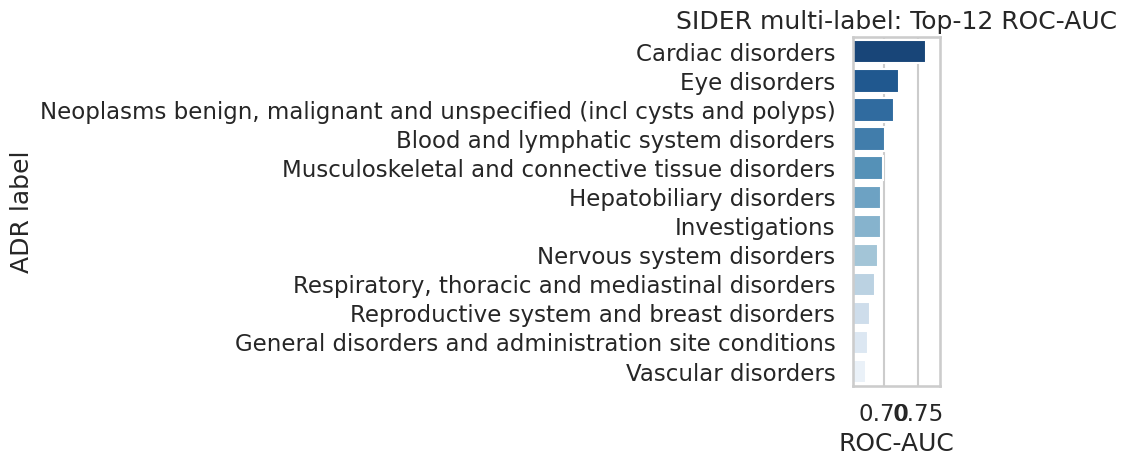

In [7]:
# 本单元格功能与目的：
# - 将 SIDER 多标签模型的逐标签 ROC-AUC 进行可视化摘要，便于快速识别性能较好的 ADR 类别。

tmp = sider_per_label.dropna(subset=["roc_auc"]).head(12).copy()
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=tmp, x="roc_auc", y="label", palette="Blues_r")
# Truncate the x-axis (not starting at 0) to make small AUC differences visible.
x = pd.to_numeric(tmp["roc_auc"], errors="coerce").dropna()
if not x.empty:
    xmin = float(x.min())
    xmax = float(x.max())
    rng = max(0.0, xmax - xmin)
    pad = max(rng * 0.20, 0.02)
    left = max(0.0, xmin - pad)
    right = min(1.0, xmax + pad)
    if (right - left) < 0.05:
        left = max(0.0, xmin - 0.05)
        right = min(1.0, xmax + 0.05)
    ax.set_xlim(left, right)
plt.title("SIDER multi-label: Top-12 ROC-AUC")
plt.xlabel("ROC-AUC")
plt.ylabel("ADR label")
plt.tight_layout()
plt.show()


## 5) 多源毒性先验融合（概率 OR 组合）

本单元格定义多源先验的融合方式，将不同数据来源得到的风险/表型概率整合为一个可用于全流程排序的综合指标。这里采用“独立 OR”的形式：

`toxicity_prior = 1 - (1-hazard_prob)*(1-clintox_prob)*(1-immune_adr_prob)`

解释：
- `hazard_prob` 反映广谱体外活性信号，对早期风险筛查敏感；
- `clintox_prob` 反映临床毒性先验，更贴近真实不良结局；
- `immune_adr_prob` 作为示例表型维度，可按需求替换为其他系统 ADR 概率或多个表型的组合。

该融合结果将作为后续候选化合物筛选、网络分析与综合评分的主排序依据之一。


,dtxsid,preferred_name,hazard_prob,clintox_prob,adr_prob::Immune system disorders,toxicity_prior
4705,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",0.962516,0.999670,0.496216,0.999994
2641,DTXSID3020918,"N,N'-Di-2-naphthyl-p-phenylenediamine",0.967374,0.999423,0.430966,0.999989
5015,DTXSID5047374,SSR161421,0.881955,0.999749,0.585091,0.999988
7103,DTXSID8023636,Telmisartan,0.851955,0.999779,0.611891,0.999987
3808,DTXSID4032374,Difethialone,0.962871,0.999094,0.580108,0.999986
309,DTXSID0027721,4-(2-Phenylpropan-2-yl)-N-[4-(2-phenylpropan-2...,0.941818,0.999413,0.483136,0.999982
6784,DTXSID7047697,Naphthalen-2-yl 2-aminobenzoate,0.886100,0.999550,0.594513,0.999979
1571,DTXSID1047310,Farglitazar,0.919110,0.999209,0.650114,0.999978
7385,DTXSID8041743,C.I. Solvent Red 24,0.916136,0.999523,0.429924,0.999977
8572,DTXSID9049245,"Dibenz[a,c]anthracene",0.903912,0.999515,0.381666,0.999971


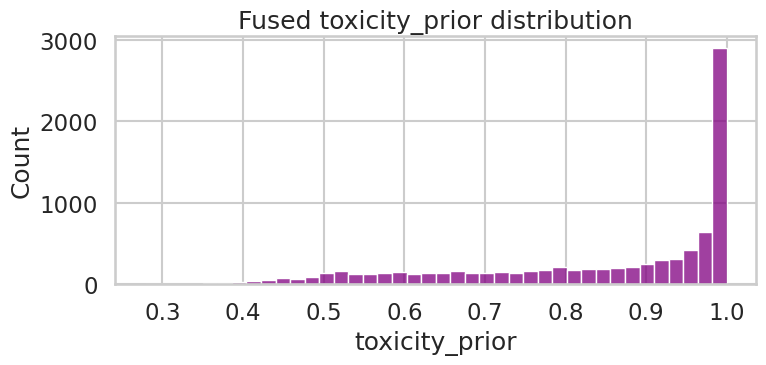

In [8]:
# 本单元格功能与目的：
# - 按既定融合公式计算 `toxicity_prior`，作为多源毒性先验的统一量化指标。
# - 展示高风险化合物样例与分布概览，并将关键中间结果与评估指标写入 `outputs/` 便于复现与复用。

chem2 = compute_toxicity_prior(
    chem2,
    hazard_col="hazard_prob",
    clintox_col="clintox_prob",
    immune_adr_col=immune_col,
    out_col="toxicity_prior",
)

display(chem2.sort_values("toxicity_prior", ascending=False).head(10)[
    ["dtxsid","preferred_name","hazard_prob","clintox_prob",immune_col,"toxicity_prior"]
])

plt.figure(figsize=(8, 4))
sns.histplot(chem2["toxicity_prior"], bins=40, color="purple")
plt.title("Fused toxicity_prior distribution")
plt.xlabel("toxicity_prior")
plt.tight_layout()
plt.show()

# Save intermediate outputs
chem2.to_csv(OUT_DIR / "chemicals_with_toxicity_priors.csv", index=False)
(OUT_DIR / "metrics_hazard.json").write_text(json.dumps(haz_metrics, indent=2, ensure_ascii=False), encoding="utf-8")
(OUT_DIR / "metrics_clintox.json").write_text(json.dumps(clintox_metrics, indent=2, ensure_ascii=False), encoding="utf-8")
(OUT_DIR / "metrics_sider.json").write_text(json.dumps(sider_metrics, indent=2, ensure_ascii=False), encoding="utf-8")
sider_per_label.to_csv(OUT_DIR / "metrics_sider_per_label.csv", index=False)


## 6) 疾病相关靶点准备（GeneCards → UniProt 序列）

本单元格说明如何从 GeneCards 结果中选择疾病相关靶点，并获取与 DTI 模型训练/推理所需的蛋白序列信息。具体做法是按 `Relevance score` 选取 Top-N 的靶点，去重后通过 UniProt REST 拉取 FASTA 序列并写入缓存；缺失序列的靶点将被过滤，以保证后续 DTI 数据构建的一致性。


selected targets: 121 unique uniprot: 121
sequences available: 121


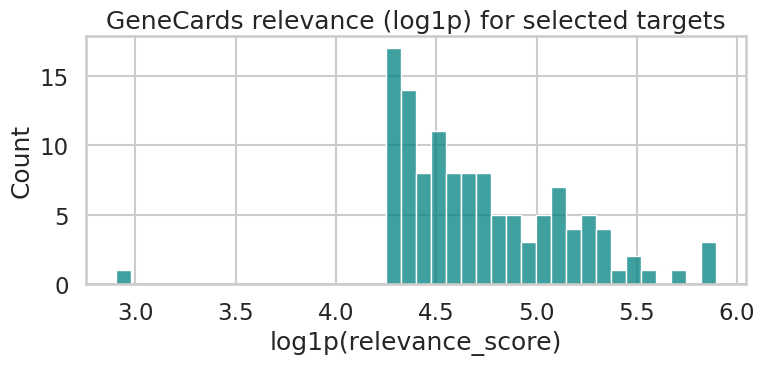

,gene_symbol,uniprot_id,relevance_score
0,BRCA2,P51587,361.377869
1,EGFR,P00533,345.411072
2,BRCA1,P38398,345.269898
3,ATM,Q13315,295.993988
4,TP53,P04637,264.356018
5,PALB2,Q86YC2,240.462494
6,CHEK2,O96017,231.834824
7,MLH1,P40692,216.729935
8,BRIP1,Q9BX63,208.775223
9,APC,P25054,201.607788


In [9]:
# 本单元格功能与目的：
# - 根据 GeneCards `relevance_score` 选取疾病相关靶点的 Top-N，并整理为去重后的 UniProt 列表。
# - 通过 UniProt REST 拉取蛋白 FASTA 序列（带缓存），过滤掉无法获取序列的靶点。
# - 对入选靶点权重做分布可视化，便于理解疾病模块权重的尺度与长尾特征。

targets_top = select_top_targets(genes, top_n=TOP_N_TARGETS_FOR_DOWNLOAD)

# Ensure downstream scoring/network steps can cover any required targets (if provided).
if REQUIRED_GENE_SYMBOLS:
    _extra_targets = (
        genes[genes["gene_symbol"].astype(str).str.strip().str.upper().isin(REQUIRED_GENE_SYMBOLS)]
        .dropna(subset=["uniprot_id"])
        .copy()
    )
    targets_top = (
        pd.concat([targets_top, _extra_targets], ignore_index=True)
        .drop_duplicates(subset=["uniprot_id"], keep="first")
        .reset_index(drop=True)
    )
uniprot_ids = ensure_unique_uniprot_ids(list(REQUIRED_UNIPROT_IDS) + targets_top["uniprot_id"].tolist())
print("selected targets:", len(targets_top), "unique uniprot:", len(uniprot_ids))

seqs = uniprot_get_sequences(uniprot_ids, cache_path=CACHE_DIR / "uniprot_sequences.csv")
print("sequences available:", len(seqs))

targets_top = targets_top[targets_top["uniprot_id"].isin(seqs.keys())].copy()
targets_top["log_relevance"] = np.log1p(targets_top["relevance_score"].astype(float))

plt.figure(figsize=(8, 4))
sns.histplot(targets_top["log_relevance"], bins=40, color="teal")
plt.title("GeneCards relevance (log1p) for selected targets")
plt.xlabel("log1p(relevance_score)")
plt.tight_layout()
plt.show()

display(targets_top.head(10)[["gene_symbol","uniprot_id","relevance_score"]])


## 7) DTI 训练数据（ChEMBL 活性）与序列-结构模型（SMILES+蛋白序列）

本单元格说明 DTI（Drug–Target Interaction）监督数据的构建原则与噪声控制策略，用于训练能够泛化到“你的化合物 × 疾病相关靶点”的相互作用预测模型。主要策略包括：

- 使用 ChEMBL 中标准化、可比的活性记录（单位 nM，常见 IC50/Ki/Kd 等），并尽量限定为 binding assays；
- 对同一化合物-靶点多次测量取中位数以降低实验噪声；
- 采用 Active/Inactive 双阈值划分（中间区域不强行标注），减少标签歧义并提升模型稳定性。


chembl activities cached: (73966, 16)


,uniprot_id,target_pref_name,target_chembl_id,molecule_chembl_id,canonical_smiles,standard_type,standard_units,standard_value,pchembl_value,assay_chembl_id,assay_description,assay_type,document_chembl_id,document_year,relation,standard_relation
0,P00533,Epidermal growth factor receptor,CHEMBL203,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,IC50,nM,41.0,7.39,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL1134862,2002.0,=,=
1,P00533,Epidermal growth factor receptor,CHEMBL203,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,IC50,nM,170.0,6.77,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL1134862,2002.0,=,=
2,P00533,Epidermal growth factor receptor,CHEMBL203,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,IC50,nM,9300.0,5.03,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL1145114,2003.0,=,=
3,P00533,Epidermal growth factor receptor,CHEMBL203,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,IC50,nM,500000.0,NaN,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL1124610,1989.0,=,=
4,P00533,Epidermal growth factor receptor,CHEMBL203,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,IC50,nM,3000000.0,NaN,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL1124610,1989.0,=,=


DTI dataset: (79185, 6)
DTI label counts: {0: 39714, 1: 39471}
DTI targets: 51


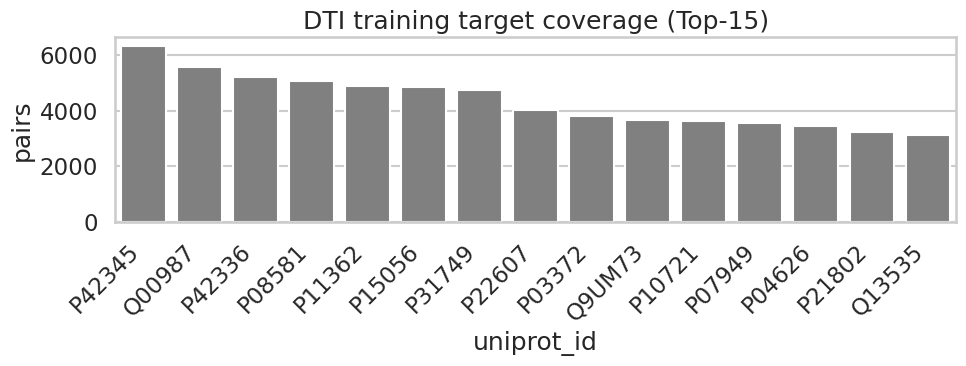

In [10]:
# 本单元格功能与目的：
# - 从 ChEMBL 拉取所选靶点的活性记录并写入缓存，形成可重复构建的监督数据来源。
# - 基于活性阈值与蛋白序列，将记录整理为 DTI 二分类训练集（drug, target, label）。
# - 输出数据规模、标签分布与靶点覆盖情况，并将构建好的数据集保存到 `outputs/`。

activities = chembl_build_training_activities(
    uniprot_ids=uniprot_ids,
    cache_path=CACHE_DIR / "chembl_activities.csv",
    max_targets=MAX_CHEMBL_TARGETS_FOR_TRAINING,
    max_records_per_target=MAX_ACTIVITIES_PER_TARGET,
    timeout_s=120,
    sleep_s=0.05,
)
print("chembl activities cached:", activities.shape)
display(activities.head())

dti = build_dti_dataset_from_chembl(
    activities,
    sequences_by_uniprot=seqs,
    active_nM=DTI_ACTIVE_NM,
    inactive_nM=DTI_INACTIVE_NM,
    neg_sample_ratio=DTI_NEG_SAMPLE_RATIO,
)
print("DTI dataset:", dti.shape)
print("DTI label counts:", dti["label"].value_counts().to_dict())
print("DTI targets:", dti["uniprot_id"].nunique())

counts_by_target = dti.groupby("uniprot_id").size().sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 4))
sns.barplot(x=counts_by_target.index, y=counts_by_target.values, color="gray")
plt.title("DTI training target coverage (Top-15)")
plt.ylabel("pairs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Save constructed DTI dataset
dti.to_csv(OUT_DIR / "dti_dataset_from_chembl.csv", index=False)


In [11]:
# 本单元格功能与目的：
# - 对 DTI 模型进行两类划分评估：随机划分（总体拟合能力）与按靶点分组划分（跨靶点泛化能力；若靶点数足够）。
# - 在全量数据上拟合最终 DTI 模型，用于后续对“你的化合物 × 疾病靶点”进行相互作用概率预测。
# - 保存模型与评估指标到 `outputs/`/`outputs/models/`，便于复用与追踪。

dti_eval_random, dti_metrics_random = train_dti_model_random_split(
    dti,
    active_nM=DTI_ACTIVE_NM,
    inactive_nM=DTI_INACTIVE_NM,
    max_features=MAX_FEATURES,
    svd_components=DTI_SVD_COMPONENTS,
    calibrate=True,
)
print("DTI metrics (random split):", json.dumps(dti_metrics_random, indent=2, ensure_ascii=False))

if dti["uniprot_id"].nunique() >= 5:
    dti_eval_group, dti_metrics_group = train_dti_model(
        dti,
        active_nM=DTI_ACTIVE_NM,
        inactive_nM=DTI_INACTIVE_NM,
        max_features=MAX_FEATURES,
        svd_components=DTI_SVD_COMPONENTS,
        calibrate=True,
    )
    print("DTI metrics (target-group split):", json.dumps(dti_metrics_group, indent=2, ensure_ascii=False))
else:
    dti_metrics_group = None
    print("Skip target-group split: too few unique targets.")

# Fit full model for downstream prediction
dti_model = fit_dti_model_full(
    dti,
    active_nM=DTI_ACTIVE_NM,
    inactive_nM=DTI_INACTIVE_NM,
    max_features=MAX_FEATURES,
    svd_components=DTI_SVD_COMPONENTS,
    calibrate=True,
)
joblib.dump(dti_model, MODEL_DIR / "dti_model.joblib")

(OUT_DIR / "metrics_dti_random.json").write_text(json.dumps(dti_metrics_random, indent=2, ensure_ascii=False), encoding="utf-8")
if dti_metrics_group is not None:
    (OUT_DIR / "metrics_dti_group.json").write_text(json.dumps(dti_metrics_group, indent=2, ensure_ascii=False), encoding="utf-8")


DTI metrics (random split): {
  "roc_auc": 0.6487125730291209,
  "pr_auc": 0.6148903340727162,
  "accuracy": 0.6039022542148134,
  "f1": 0.6012839255068964,
  "n_train_pairs": 63348.0,
  "n_test_pairs": 15837.0
}
DTI metrics (target-group split): {
  "roc_auc": 0.7124045493243383,
  "pr_auc": 0.7066702339372954,
  "accuracy": 0.510348009491168,
  "f1": 0.03582089552238806,
  "n_train_pairs": 64013.0,
  "n_test_pairs": 15172.0,
  "n_train_targets": 40.0,
  "n_test_targets": 11.0
}


## 8) 组合：毒性先验 + DTI → 化合物-靶点候选对评分（Impact v2）

本单元格说明如何将 DTI 预测的相互作用概率与多源毒性先验、疾病相关性权重联合起来，为化合物-靶点候选对生成统一的综合评分。流程上先用 `toxicity_prior` 在化合物侧做筛选/排序，再对候选靶点进行打分并输出 Top pairs；综合得分 `impact_score_v2` 将作为后续网络扩散与可解释性分析的输入。


scoring chemicals: (201, 46) targets: (121, 6)
pairs: (24321, 9)


,dtxsid,preferred_name,smiles,hazard_prob,gene_symbol,uniprot_id,relevance_score,interaction_prob,impact_score,toxicity_prior,clintox_prob,adr_prob::Immune system disorders,adr_prob::Hepatobiliary disorders,adr_prob::Cardiac disorders,impact_score_v2
0,DTXSID4023545,Pyrvinium pamoate,CN(C)C1=CC=C2C(C=CC(\C=C\C3=C(C)N(C(C)=C3)C3=C...,0.947875,PIK3CA,P42336,150.548050,0.546426,2.600546,0.999945,0.997790,0.525949,0.612672,0.699931,2.743404
1,DTXSID5045091,Buclizine dihydrochloride,Cl.Cl.CC(C)(C)C1=CC=C(CN2CCN(CC2)C(C2=CC=CC=C2...,0.910580,PIK3CA,P42336,150.548050,0.545668,2.494758,0.999834,0.996468,0.473737,0.378943,0.395907,2.739292
2,DTXSID9045348,Meclozine dihydrochloride,Cl.Cl.CC1=CC=CC(CN2CCN(CC2)C(C2=CC=CC=C2)C2=CC...,0.869086,PIK3CA,P42336,150.548050,0.544501,2.375983,0.999843,0.997743,0.469370,0.384174,0.465321,2.733457
3,DTXSID0032520,Azoxystrobin,CO\C=C(\C(=O)OC)C1=CC=CC=C1OC1=CC(OC2=CC=CC=C2...,0.793812,BRCA2,P51587,361.377869,0.462352,2.162739,0.999829,0.998214,0.536072,0.647500,0.591442,2.724033
4,DTXSID7024110,Fluvalinate,CC(C)C(NC1=C(Cl)C=C(C=C1)C(F)(F)F)C(=O)OC(C#N)...,0.932685,BRCA2,P51587,361.377869,0.456895,2.511105,0.999849,0.995782,0.466700,0.675035,0.575860,2.691932
5,DTXSID4032667,Es-fenvalerate,CC(C)[C@H](C(=O)O[C@H](C#N)C1=CC=CC(OC2=CC=CC=...,0.892833,PIK3CA,P42336,150.548050,0.535953,2.402586,0.999884,0.997834,0.501815,0.599188,0.555159,2.690657
6,DTXSID0032520,Azoxystrobin,CO\C=C(\C(=O)OC)C1=CC=CC=C1OC1=CC(OC2=CC=CC=C2...,0.793812,ATM,Q13315,295.993988,0.472008,2.133351,0.999829,0.998214,0.536072,0.647500,0.591442,2.687019
7,DTXSID7024110,Fluvalinate,CC(C)C(NC1=C(Cl)C=C(C=C1)C(F)(F)F)C(=O)OC(C#N)...,0.932685,ATM,Q13315,295.993988,0.471588,2.504338,0.999849,0.995782,0.466700,0.675035,0.575860,2.684677
8,DTXSID4023545,Pyrvinium pamoate,CN(C)C1=CC=C2C(C=CC(\C=C\C3=C(C)N(C(C)=C3)C3=C...,0.947875,BRCA2,P51587,361.377869,0.455358,2.543416,0.999945,0.997790,0.525949,0.612672,0.699931,2.683135
9,DTXSID2044503,C.I. Disperse Yellow 64,OC1=C(N=C2C=CC=CC2=C1Br)C1C(=O)C2=C(C=CC=C2)C1=O,0.918121,ATM,Q13315,295.993988,0.470565,2.459889,0.999907,0.997542,0.536044,0.729955,0.614621,2.679014


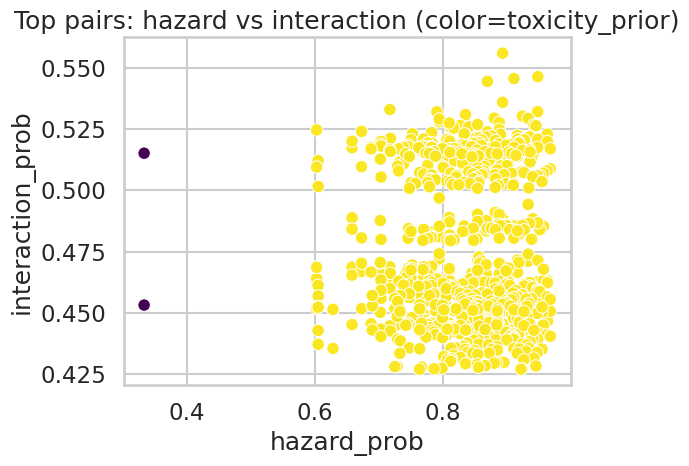

In [12]:
# 本单元格功能与目的：
# - 基于 `toxicity_prior` 选取 Top 化合物，并对候选靶点计算 DTI 相互作用概率，生成化合物-靶点候选对表。
# - 将毒性先验、关键 ADR 概率与疾病相关性权重合并到候选对中，计算综合评分 `impact_score_v2` 并输出排序结果。
# - 通过散点图从 risk（hazard）与 interaction 两个维度检查 Top pairs 的分布特征。

# Build scoring subsets (top-K + required coverage)
chem_for_scoring = (
    chem2.sort_values("toxicity_prior", ascending=False, kind="mergesort")
    .head(TOP_K_CHEMICALS_FOR_SCORING)
    .copy()
)
if REQUIRED_DTXSIDS:
    _extra_chems = chem2[chem2["dtxsid"].astype(str).isin(REQUIRED_DTXSIDS)].copy()
    chem_for_scoring = (
        pd.concat([chem_for_scoring, _extra_chems], ignore_index=True)
        .drop_duplicates(subset=["dtxsid"], keep="first")
        .reset_index(drop=True)
    )

# Restrict targets to those with available sequences (plus any required targets)
targets_with_seq = genes[genes["uniprot_id"].astype(str).isin(seqs.keys())].copy()
if "relevance_score" in targets_with_seq.columns:
    targets_with_seq = targets_with_seq.sort_values("relevance_score", ascending=False, kind="mergesort")

targets_for_scoring = targets_with_seq.head(TOP_K_TARGETS_FOR_SCORING).copy()
if REQUIRED_GENE_SYMBOLS:
    _extra_targets = (
        genes[genes["gene_symbol"].astype(str).str.strip().str.upper().isin(REQUIRED_GENE_SYMBOLS)]
        .dropna(subset=["uniprot_id"])
        .copy()
    )
    _extra_targets = _extra_targets[_extra_targets["uniprot_id"].astype(str).isin(seqs.keys())].copy()
    targets_for_scoring = (
        pd.concat([targets_for_scoring, _extra_targets], ignore_index=True)
        .drop_duplicates(subset=["uniprot_id"], keep="first")
        .reset_index(drop=True)
    )

print("scoring chemicals:", chem_for_scoring.shape, "targets:", targets_for_scoring.shape)

pairs = score_chemical_target_pairs(
    chemicals=chem_for_scoring,
    targets=targets_for_scoring,
    sequences_by_uniprot=seqs,
    hazard_model=haz_model,
    dti_model=dti_model,
    top_k_chemicals=len(chem_for_scoring),
    top_k_targets=len(targets_for_scoring),
    rank_chemicals_by="toxicity_prior",
    hazard_prob_col="hazard_prob",
    use_existing_hazard_prob=True,
)
print("pairs:", pairs.shape)

# Optional: validate that required pairs are present in the scored table
if not REQUIRED_PAIRS.empty:
    _chk = REQUIRED_PAIRS.merge(
        pairs[["dtxsid","gene_symbol"]].drop_duplicates(),
        on=["dtxsid","gene_symbol"],
        how="left",
        indicator=True,
    )
    n_missing = int((_chk["_merge"] != "both").sum())
    if n_missing:
        raise ValueError(f"Missing required pairs in scored table: {n_missing}")

# Merge toxicity_prior and key ADR probs into pairs
chem_key = chem2[["dtxsid","toxicity_prior","clintox_prob",immune_col,hepato_col,cardiac_col]].copy()
pairs = pairs.merge(chem_key, on="dtxsid", how="left")

# Compute v2 score (without network term yet)
pairs = compute_pair_impact_score(
    pairs,
    toxicity_prior_col="toxicity_prior",
    interaction_prob_col="interaction_prob",
    relevance_col="relevance_score",
    out_col="impact_score_v2",
)
pairs = pairs.sort_values("impact_score_v2", ascending=False).reset_index(drop=True)

pairs.to_csv(OUT_DIR / "ranked_chemical_target_pairs_v2.csv", index=False)

display(pairs.head(20))

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pairs.head(800),
    x="hazard_prob",
    y="interaction_prob",
    hue="toxicity_prior",
    palette="viridis",
    legend=False,
)
plt.title("Top pairs: hazard vs interaction (color=toxicity_prior)")
plt.tight_layout()
plt.show()


## 9) 网络医学：STRING PPI 构网 + RWR 扩散（机制与生物标志物线索）

本单元格说明网络传播分析的步骤与输出，用于把“化合物-靶点作用”投影到蛋白互作网络上，从系统层面评估对疾病模块的潜在扰动，并提取可能的机制/生物标志物基因。

步骤：
1) 以疾病相关靶点（UniProt）为种子，从 STRING 拉取高置信 PPI 子网（可按需加入一跳邻居以增强连通性）；
2) 对每个高风险化合物，选取其 DTI 预测的高置信靶点作为“种子节点”，在 PPI 上执行 Random Walk with Restart；
3) 形成两类输出：化合物的疾病模块扰动得分（加权聚合）与候选机制/生物标志物基因列表（高扩散得分且不属于已知疾病基因集合）。


PPI edges: (5292, 7)


,string_id_a,string_id_b,preferred_a,preferred_b,score,uniprot_a,uniprot_b
0,9606.ENSP00000013807,9606.ENSP00000265433,ERCC1,NBN,0.700,NaN,NaN
1,9606.ENSP00000013807,9606.ENSP00000347232,ERCC1,BLM,0.701,NaN,NaN
2,9606.ENSP00000013807,9606.ENSP00000259008,ERCC1,BRIP1,0.716,NaN,NaN
3,9606.ENSP00000013807,9606.ENSP00000382628,ERCC1,RBBP8,0.722,NaN,NaN
4,9606.ENSP00000013807,9606.ENSP00000426191,ERCC1,RAD17,0.731,NaN,NaN


PPI nodes: 266


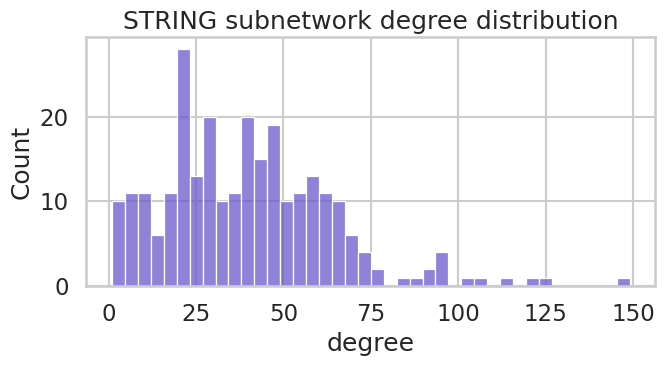

In [13]:
# 本单元格功能与目的：
# - 以疾病相关靶点为种子，从 STRING 获取高置信 PPI 边并缓存，构建用于网络传播的互作子网。
# - 将边表转换为可用于随机游走的图索引结构，并用度分布对网络规模与稠密度做快速检查。

ppi_edges = string_build_ppi_cache(
    identifiers=targets_top["uniprot_id"].tolist(),
    cache_path=CACHE_DIR / "string_ppi_edges.csv",
    required_score=STRING_REQUIRED_SCORE,
    add_nodes=STRING_ADD_NODES,
    timeout_s=120,
)
print("PPI edges:", ppi_edges.shape)
display(ppi_edges.head())

ppi = build_ppi_index(ppi_edges)
print("PPI nodes:", len(ppi.nodes))

# Degree distribution
deg = np.asarray(ppi.adjacency.astype(bool).sum(axis=0)).ravel()
plt.figure(figsize=(7, 4))
sns.histplot(deg, bins=40, color="slateblue")
plt.title("STRING subnetwork degree distribution")
plt.xlabel("degree")
plt.tight_layout()
plt.show()


network chemicals: (31, 46)


,dtxsid,preferred_name,toxicity_prior,disease_module_score
8,DTXSID8041743,C.I. Solvent Red 24,0.999977,4.505482
10,DTXSID9020538,"N,N'-Diphenyl-p-phenylenediamine",0.999967,4.503757
11,DTXSID8030423,"5,6-Benzoflavone",0.999967,4.503718
23,DTXSID1034181,Raloxifene hydrochloride,0.999940,4.503683
14,DTXSID3023550,Raloxifene,0.999962,4.503682
19,DTXSID5037739,4-Anilinophenol,0.999946,4.503639
28,DTXSID1021031,4-Nitrosodiphenylamine,0.999929,4.503605
27,DTXSID8022408,Phenol red,0.999933,4.495885
25,DTXSID7020184,C.I. Direct Black 38,0.999938,4.494731
20,DTXSID4023545,Pyrvinium pamoate,0.999945,4.493673


,dtxsid,preferred_name,biomarker_gene,biomarker_score
12,DTXSID0021125,Phenolphthalein,RAD51D-2,0.000677
26,DTXSID0023909,Benzo[k]fluoranthene,RAD51D-2,0.000678
5,DTXSID0027721,4-(2-Phenylpropan-2-yl)-N-[4-(2-phenylpropan-2...,RAD51D-2,0.000664
28,DTXSID1021031,4-Nitrosodiphenylamine,RAD51D-2,0.000677
24,DTXSID1026293,D&C Violet 2,RAD51D-2,0.000674
23,DTXSID1034181,Raloxifene hydrochloride,RAD51D-2,0.000676
13,DTXSID1038876,Phenyl 1-hydroxy-2-naphthoate,RAD51D-2,0.000680
7,DTXSID1047310,Farglitazar,RAD51D-2,0.000550
30,DTXSID2021781,"Dibutyl 1,2-benzenedicarboxylate",RAD51D-2,0.000892
17,DTXSID2025210,C.I. Disperse Red 60,RAD51D-2,0.000676


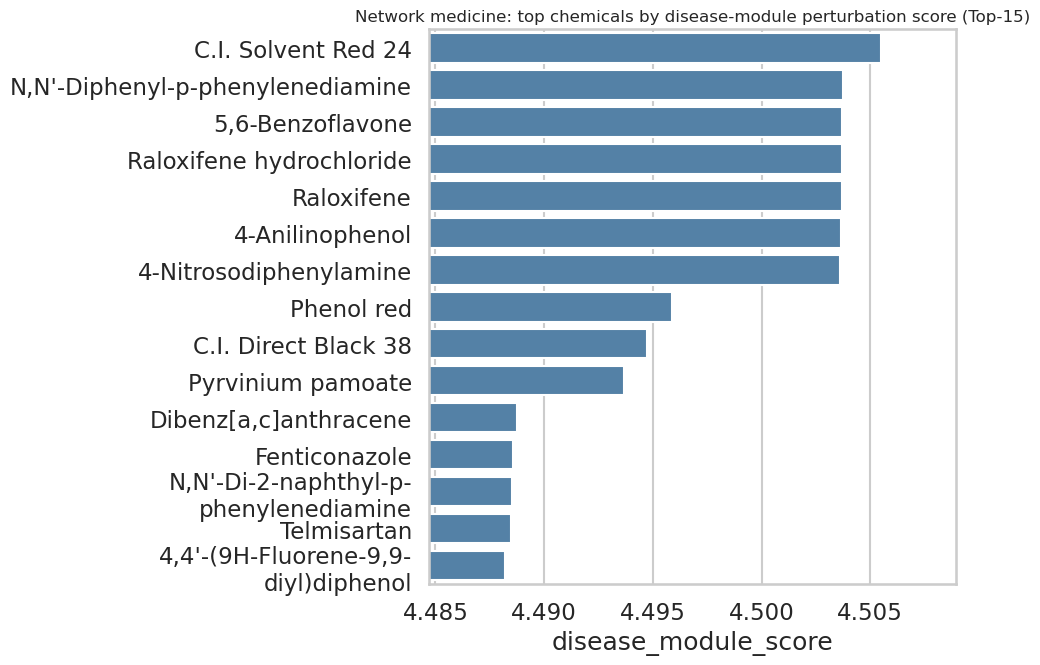

In [14]:
# 本单元格功能与目的：
# - 将 GeneCards 相关性权重转为疾病模块权重，并选取 `toxicity_prior` 最高的化合物作为网络分析对象。
# - 对每个化合物以其高置信 DTI 靶点为种子执行 RWR，得到基因稳态扩散得分；据此计算疾病模块扰动得分并提取候选生物标志物基因。
# - 保存网络得分与生物标志物结果表，并对 Top 化合物的模块得分进行可视化汇总。

disease_weights = (
    genes.dropna(subset=["gene_symbol","relevance_score"])
    .groupby("gene_symbol", as_index=True)["relevance_score"].max()
)
disease_logw = np.log1p(disease_weights).to_dict()

# Choose top chemicals for network analysis
top_chems = chem2.sort_values("toxicity_prior", ascending=False, kind="mergesort").head(TOP_CHEMICALS_FOR_NETWORK).copy()
if REQUIRED_DTXSIDS:
    _extra = chem2[chem2["dtxsid"].astype(str).isin(REQUIRED_DTXSIDS)].copy()
    top_chems = (
        pd.concat([top_chems, _extra], ignore_index=True)
        .drop_duplicates(subset=["dtxsid"], keep="first")
        .reset_index(drop=True)
    )
print("network chemicals:", top_chems.shape)

# For speed, restrict pairs
pairs_small = pairs[pairs["dtxsid"].isin(top_chems["dtxsid"])].copy()

def build_seeds_for_chemical(dtxsid: str) -> dict[str, float]:
    sub = pairs_small[pairs_small["dtxsid"] == dtxsid].copy()
    sub = sub.sort_values("interaction_prob", ascending=False).head(TOP_SEED_TARGETS_PER_CHEM)
    seeds = {}
    for _, r in sub.iterrows():
        g = str(r.get("gene_symbol", "")).strip()
        if not g:
            continue
        seeds[g] = float(r["interaction_prob"])
    return seeds

network_rows = []
biomarker_rows = []
gene_score_by_chem = {}

for _, crow in top_chems.iterrows():
    cid = crow["dtxsid"]
    seeds = build_seeds_for_chemical(cid)
    rwr = random_walk_with_restart(ppi, seeds, restart_prob=RWR_RESTART)
    rwr = rwr.sort_values("score", ascending=False).reset_index(drop=True)
    gene_score_by_chem[cid] = dict(zip(rwr["node"], rwr["score"]))

    # disease module score
    module = 0.0
    for g, w in disease_logw.items():
        module += float(gene_score_by_chem[cid].get(g, 0.0)) * float(w)
    network_rows.append({
        "dtxsid": cid,
        "preferred_name": crow.get("preferred_name"),
        "toxicity_prior": float(crow.get("toxicity_prior")),
        "disease_module_score": module,
    })

    # top biomarkers: high-score genes outside disease list
    disease_set = set(disease_logw.keys())
    bm = rwr[~rwr["node"].isin(disease_set)].head(20)
    for _, br in bm.iterrows():
        biomarker_rows.append({
            "dtxsid": cid,
            "preferred_name": crow.get("preferred_name"),
            "biomarker_gene": br["node"],
            "biomarker_score": float(br["score"]),
        })

network_scores = pd.DataFrame(network_rows).sort_values("disease_module_score", ascending=False)
biomarkers = pd.DataFrame(biomarker_rows).sort_values(["dtxsid","biomarker_score"], ascending=[True, False])

network_scores.to_csv(OUT_DIR / "network_scores_by_chemical.csv", index=False)
biomarkers.to_csv(OUT_DIR / "network_biomarkers_top20_per_chemical.csv", index=False)

display(network_scores.head(10))
display(biomarkers.head(20))

import textwrap
top_scores = network_scores.head(15).copy()
top_scores["preferred_name_wrapped"] = top_scores["preferred_name"].astype(str).map(lambda s: textwrap.fill(s, width=32))

plt.figure(figsize=(10, 7))
ax = sns.barplot(data=top_scores, y="preferred_name_wrapped", x="disease_module_score", color="steelblue")
ax.set_title("Network medicine: top chemicals by disease-module perturbation score (Top-15)", fontsize=12)
ax.set_xlabel("disease_module_score")
ax.set_ylabel("")
# Truncate the x-axis (not starting at 0) to emphasize small rank differences.
x = pd.to_numeric(top_scores["disease_module_score"], errors="coerce").dropna()
if not x.empty:
    xmin = float(x.min())
    xmax = float(x.max())
    rng = max(0.0, xmax - xmin)
    pad = max(rng * 0.20, 0.002)
    ax.set_xlim(xmin - pad, xmax + pad)
plt.tight_layout()
plt.show()


## 10) 将网络基因得分回填到候选对表，并计算融合网络项的综合评分

本单元格将 RWR 得到的基因稳态得分 `network_gene_score` 回填到每个 (chemical, target) 候选对，用于刻画该靶点在“化合物诱导的网络扩散”中的中心程度。随后在 `impact_score_v2` 的基础上引入网络项，计算：

`impact_score_v2_network = toxicity_prior * interaction_prob * log1p(relevance_score) * network_gene_score`

该得分用于对候选化合物-靶点对进行更可解释的排序，并为后续通路聚合提供输入。


,dtxsid,preferred_name,smiles,hazard_prob,gene_symbol,uniprot_id,relevance_score,interaction_prob,impact_score,toxicity_prior,clintox_prob,adr_prob::Immune system disorders,adr_prob::Hepatobiliary disorders,adr_prob::Cardiac disorders,impact_score_v2,network_gene_score,impact_score_v2_network
0,DTXSID4023545,Pyrvinium pamoate,CN(C)C1=CC=C2C(C=CC(\C=C\C3=C(C)N(C(C)=C3)C3=C...,0.947875,PIK3CA,P42336,150.548050,0.546426,2.600546,0.999945,0.997790,0.525949,0.612672,0.699931,2.743404,0.027700,0.075992
1,DTXSID1038876,Phenyl 1-hydroxy-2-naphthoate,OC1=C(C=CC2=C1C=CC=C2)C(=O)OC1=CC=CC=C1,0.855992,TP53,P04637,264.356018,0.470048,2.245583,0.999962,0.999347,0.599329,0.664064,0.592638,2.623272,0.028677,0.075228
2,DTXSID8041743,C.I. Solvent Red 24,CC1=CC=CC=C1N=NC1=CC(C)=C(C=C1)N=NC1=C(O)C=CC2...,0.916136,TP53,P04637,264.356018,0.466541,2.385435,0.999977,0.999523,0.429924,0.594119,0.509401,2.603740,0.028799,0.074986
3,DTXSID2025210,C.I. Disperse Red 60,NC1=C2C(=O)C3=C(C=CC=C3)C(=O)C2=C(O)C=C1OC1=CC...,0.857333,TP53,P04637,264.356018,0.470822,2.252806,0.999955,0.998932,0.706697,0.650929,0.484766,2.627574,0.028439,0.074727
4,DTXSID6034392,Boscalid,ClC1=CC=C(C=C1)C1=C(NC(=O)C2=C(Cl)N=CC=C2)C=CC=C1,0.852833,TP53,P04637,264.356018,0.463368,2.205504,0.999957,0.999377,0.530821,0.588278,0.438462,2.585980,0.028826,0.074543
5,DTXSID3023550,Raloxifene,OC1=CC=C(C=C1)C1=C(C(=O)C2=CC=C(OCCN3CCCCC3)C=...,0.947606,PIK3CA,P42336,150.548050,0.532136,2.531819,0.999962,0.998401,0.544603,0.598274,0.527911,2.671703,0.027897,0.074533
6,DTXSID4023545,Pyrvinium pamoate,CN(C)C1=CC=C2C(C=CC(\C=C\C3=C(C)N(C(C)=C3)C3=C...,0.947875,AKT1,P31749,132.607315,0.520898,2.416839,0.999945,0.997790,0.525949,0.612672,0.699931,2.549605,0.029227,0.074516
7,DTXSID7048875,Mecloqualone,CC1=NC2=C(C=CC=C2)C(=O)N1C1=C(Cl)C=CC=C1,0.805850,TP53,P04637,264.356018,0.463350,2.083923,0.999945,0.999166,0.661748,0.768974,0.612667,2.585850,0.028720,0.074265
8,DTXSID1034181,Raloxifene hydrochloride,Cl.OC1=CC=C(C=C1)C1=C(C(=O)C2=CC=C(OCCN3CCCCC3...,0.923764,PIK3CA,P42336,150.548050,0.530268,2.459451,0.999940,0.998331,0.531017,0.582316,0.505268,2.662264,0.027892,0.074257
9,DTXSID4032374,Difethialone,OC1=C(C2CC(CC3=C2C=CC=C3)C2=CC=C(C=C2)C2=CC=C(...,0.962871,TP53,P04637,264.356018,0.462277,2.484207,0.999986,0.999094,0.580108,0.695684,0.562150,2.579963,0.028600,0.073788


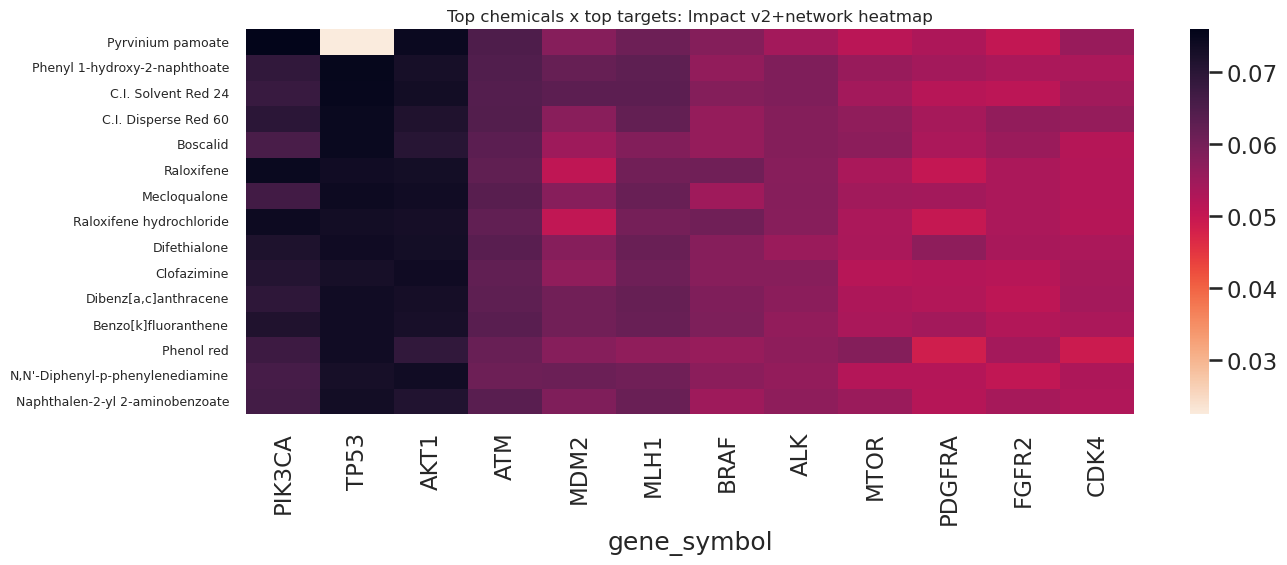

In [15]:
# 本单元格功能与目的：
# - 将每个化合物对应的 RWR 基因得分回填到候选对表，得到每个 (chemical, target) 对的 `network_gene_score`。
# - 计算融合网络项的 `impact_score_v2_network` 并输出最终排序结果，用于更强调网络可达性的候选对优先级。
# - 以热图形式展示 Top 化合物 × Top 靶点的综合得分矩阵，便于快速观察整体模式。

pairs_net = pairs.copy()
pairs_net["network_gene_score"] = 0.0

for i, r in pairs_net.iterrows():
    cid = r["dtxsid"]
    g = str(r.get("gene_symbol", "")).strip()
    if not g:
        continue
    pairs_net.at[i, "network_gene_score"] = float(gene_score_by_chem.get(cid, {}).get(g, 0.0))

pairs_net = compute_pair_impact_score(
    pairs_net,
    toxicity_prior_col="toxicity_prior",
    interaction_prob_col="interaction_prob",
    relevance_col="relevance_score",
    network_gene_score_col="network_gene_score",
    out_col="impact_score_v2_network",
)
pairs_net = pairs_net.sort_values("impact_score_v2_network", ascending=False).reset_index(drop=True)
pairs_net.to_csv(OUT_DIR / "ranked_chemical_target_pairs_v2_network.csv", index=False)

display(pairs_net.head(20))

# Heatmap of top chemicals x top targets
chem_rank = pairs_net.groupby("preferred_name", as_index=True)["impact_score_v2_network"].max().sort_values(ascending=False)
tgt_rank = pairs_net.groupby("gene_symbol", as_index=True)["impact_score_v2_network"].max().sort_values(ascending=False)
topC = chem_rank.head(15).index.astype(str).tolist()
topT = tgt_rank.head(12).index.astype(str).tolist()
mat = (
    pairs_net[pairs_net["preferred_name"].astype(str).isin(topC) & pairs_net["gene_symbol"].astype(str).isin(topT)]
    .pivot_table(index="preferred_name", columns="gene_symbol", values="impact_score_v2_network", aggfunc="max")
    .reindex(index=topC, columns=topT)
    .fillna(0.0)
)
import textwrap
plt.figure(figsize=(14, 6))
ax = sns.heatmap(mat, cmap="rocket_r")
ax.set_title("Top chemicals x top targets: Impact v2+network heatmap", fontsize=12)
ax.set_ylabel("")
ax.set_yticklabels([textwrap.fill(t.get_text(), width=36) for t in ax.get_yticklabels()], fontsize=9)
plt.tight_layout()
plt.show()


## 11) 通路层解释：Reactome 映射与通路影响评分

本单元格用于将候选靶点与网络扩散得到的高分基因映射到 Reactome 通路，并在化合物层面聚合基因得分，得到通路影响评分。通路维度的汇总有助于从“基因列表”上升到“生物过程/机制模块”，便于结果解读与下游验证设计。


reactome mapping: (1721, 6)


,uniprot_id,reactome_st_id,pathway_name,species_name,is_in_disease,has_diagram
0,P51587,R-HSA-5685939,HDR through MMEJ (alt-NHEJ),Homo sapiens,False,True
1,P51587,R-HSA-5685942,HDR through Homologous Recombination (HRR),Homo sapiens,False,False
2,P51587,R-HSA-5693554,Resolution of D-loop Structures through Synthe...,Homo sapiens,False,False
3,P51587,R-HSA-5693568,Resolution of D-loop Structures through Hollid...,Homo sapiens,False,False
4,P51587,R-HSA-5693579,Homologous DNA Pairing and Strand Exchange,Homo sapiens,False,False


,dtxsid,preferred_name,pathway_name,pathway_impact
0,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",PIP3 activates AKT signaling,0.198083
1,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol","PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling",0.174102
2,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",Constitutive Signaling by Aberrant PI3K in Cancer,0.145550
3,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",Regulation of TP53 Activity through Phosphoryl...,0.144947
4,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",Regulation of TP53 Degradation,0.138110
5,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",TP53 Regulates Transcription of DNA Repair Genes,0.136542
6,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",RAF/MAP kinase cascade,0.133334
7,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",Signaling by SCF-KIT,0.119077
8,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",G2/M DNA damage checkpoint,0.116413
9,DTXSID5037731,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",Interleukin-4 and Interleukin-13 signaling,0.111293


/tmp/ipykernel_491308/2183595260.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sub, x="pathway_impact", y="pathway_name_wrapped", palette="Greens_r")


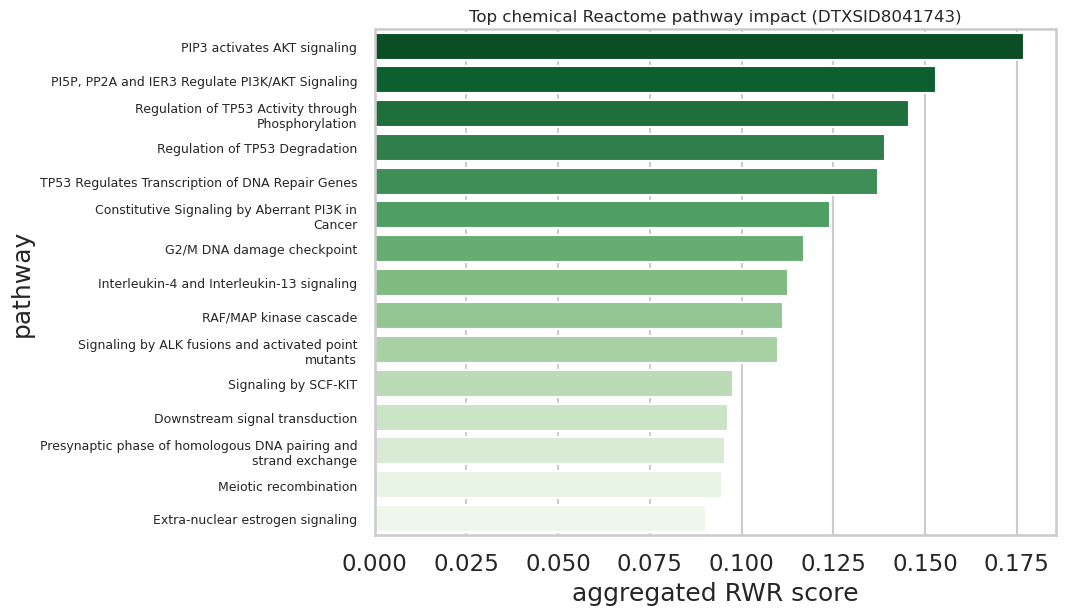

In [16]:
# 本单元格功能与目的：
# - 将候选生物标志物基因映射到 UniProt（优先 reviewed），并与疾病靶点一起建立 UniProt→Reactome 通路映射缓存。
# - 在化合物层面按 RWR 基因得分对通路进行聚合，得到通路影响评分并输出 Top 通路列表。
# - 绘制代表性化合物对应的 Top 通路，用于机制层面的解释与对照分析。

top_biomarker_genes = biomarkers["biomarker_gene"].dropna().astype(str).unique().tolist()[:200]
gene2uni = uniprot_map_gene_symbols_to_accessions(
    top_biomarker_genes,
    cache_path=CACHE_DIR / "uniprot_gene_symbol_map.csv",
    reviewed=True,
    timeout_s=120,
)

# Collect UniProt ids for pathway mapping
uni_for_pathways = set(targets_top["uniprot_id"].astype(str).tolist()) | set(gene2uni.values())
reactome_map = reactome_build_mapping(
    sorted(uni_for_pathways),
    cache_path=CACHE_DIR / "reactome_uniprot_pathways.csv",
    timeout_s=120,
)
print("reactome mapping:", reactome_map.shape)
display(reactome_map.head())

# Build UniProt->pathways list
uni_to_paths = reactome_map.groupby("uniprot_id")["pathway_name"].apply(list).to_dict()

# Build gene symbol -> UniProt for disease genes where possible
disease_gene_to_uni = targets_top.dropna(subset=["gene_symbol","uniprot_id"]).set_index("gene_symbol")["uniprot_id"].to_dict()

def pathways_for_gene(gene_symbol: str) -> list[str]:
    uid = disease_gene_to_uni.get(gene_symbol) or gene2uni.get(gene_symbol)
    if not uid:
        return []
    return uni_to_paths.get(uid, [])

# Pathway impact per chemical (aggregate RWR scores)
path_rows = []
for _, crow in top_chems.iterrows():
    cid = crow["dtxsid"]
    scores = gene_score_by_chem.get(cid, {})
    accum = {}
    for g, s in scores.items():
        for p in pathways_for_gene(g):
            accum[p] = accum.get(p, 0.0) + float(s)
    for p, val in sorted(accum.items(), key=lambda x: x[1], reverse=True)[:40]:
        path_rows.append({
            "dtxsid": cid,
            "preferred_name": crow.get("preferred_name"),
            "pathway_name": p,
            "pathway_impact": float(val),
        })

path_imp = pd.DataFrame(path_rows, columns=["dtxsid","preferred_name","pathway_name","pathway_impact"])
path_imp.to_csv(OUT_DIR / "reactome_pathway_impact_top40_per_chemical.csv", index=False)
display(path_imp.head(20))

# Plot top pathways for the top-ranked chemical by network score
if path_imp.empty:
    print("No Reactome pathway mapping available -> skip pathway plots.")
else:
    top_cid = network_scores.iloc[0]["dtxsid"] if not network_scores.empty else top_chems.iloc[0]["dtxsid"]
    import textwrap
    sub = path_imp[path_imp["dtxsid"] == top_cid].sort_values("pathway_impact", ascending=False).head(15).copy()
    sub["pathway_name_wrapped"] = sub["pathway_name"].astype(str).map(lambda s: textwrap.fill(s, width=48))
    plt.figure(figsize=(11, 6.5))
    ax = sns.barplot(data=sub, x="pathway_impact", y="pathway_name_wrapped", palette="Greens_r")
    ax.set_title(f"Top chemical Reactome pathway impact ({top_cid})", fontsize=12)
    plt.xlabel("aggregated RWR score")
    plt.ylabel("pathway")
    ax.tick_params(axis="y", labelsize=9)
    plt.tight_layout()
    plt.show()


## 11b) CTX Hazard API 注释与外部证据补充（可选）

本单元格说明一个可选的外部证据补充环节：如果配置了 CTX API Key，可调用 US EPA 的 CTX Hazard API 为 Top 化合物检索遗传毒性、致癌性及皮肤/眼相关的 hazard 摘要信息。该部分旨在为模型输出提供独立数据源的证据支持，并生成可直接保存/汇总的结果表。

使用方式：
- 优先通过环境变量 `CTX_API_KEY` 提供密钥；若未设置将自动跳过该环节；
- 输出文件将写入 `outputs/`（同时在 `data_external/` 内缓存接口返回以便复用）。


,id,ames,clowderDocId,dtxsid,genetoxCall,genetoxSummaryId,micronucleus,reportsNegative,reportsOther,reportsPositive
0,2082,negative,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0021125,positive,2082,positive,4,0,1
1,321,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0022432,positive,321,positive,6,0,8
2,728,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0023878,positive,728,negative,19,0,4
3,1256,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0023909,positive,1256,NaN,0,0,2
4,1258,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0024559,positive,1258,NaN,0,0,2
5,4545,negative,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID0027721,negative,4543,NaN,3,0,0
6,381,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID1021031,positive,381,NaN,0,0,7
7,330,positive,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID1021247,positive,330,negative,7,2,8
8,5261,negative,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID1025431,negative,5259,NaN,1,0,0
9,5266,negative,https://clowder.edap-cluster.com/files/680b9b1...,DTXSID1025485,negative,5264,negative,4,0,0


,id,dtxsid,source,exposureRoute,cancerCall,url
0,1808,DTXSID0021125,IARC,-,Group 2B - Possibly carcinogenic to humans,https://monographs.iarc.who.int/list-of-classi...
1,2926,DTXSID0021125,CalEPA,-,Known human carcinogen,https://oehha.ca.gov/proposition-65/propositio...
2,738,DTXSID0021125,NTP RoC,-,Reasonably Anticipated to be a Human Carcinogen,https://ntp.niehs.nih.gov/whatwestudy/assessme...
3,2649,DTXSID0022432,CalEPA,-,Known human carcinogen,https://oehha.ca.gov/proposition-65/propositio...
4,8,DTXSID0022432,NIOSH,inhalation,potential occupational carcinogen,https://www.cdc.gov/niosh/topics/cancer/npotoc...
5,198,DTXSID0022432,IRIS,-,B2 (Probable human carcinogen - based on suffi...,https://cfpub.epa.gov/ncea/iris/search/index.cfm
6,1676,DTXSID0022432,IARC,-,Group 2B - Possibly carcinogenic to humans,https://monographs.iarc.who.int/list-of-classi...
7,123,DTXSID0023878,IRIS,-,D (Not classifiable as to human carcinogenicity),https://cfpub.epa.gov/ncea/iris/search/index.cfm
8,1103,DTXSID0023878,IARC,-,Group 3 - Not classifiable as to its carcinoge...,https://monographs.iarc.who.int/list-of-classi...
9,826,DTXSID0023909,NTP RoC,-,Reasonably Anticipated to be a Human Carcinogen,https://ntp.niehs.nih.gov/whatwestudy/assessme...


,id,authority,classification,dtxsid,endpoint,glp,guideline,recordUrl,reliability,resultText,score,skinEyeHash,skinEyeId,skinEyeUuid,source,species,strain,studyType,year
0,55190,Screening,Not likely to be sensitizing,DTXSID0021125,skin sensitisation: in vivo (LLNA),yes (incl. certificate),according to OECD Guideline 429 (Skin Sensitis...,https://echa.europa.eu/registration-dossier/-/...,1 (reliable without restriction),not sensitising Migrated information,L,-,400021,NaN,ECHA eChemPortal,mouse,cba/caolahsd,skin sensitization,2010
1,30215,Screening,Classification not possible,DTXSID0021125,Eye Irritation,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,353458,NaN,Japan,-,-,-,-1
2,30216,Screening,Classification not possible,DTXSID0021125,Skin Irritation,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,353459,NaN,Japan,-,-,-,-1
3,30217,Screening,Classification not possible,DTXSID0021125,Skin Sensitization,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,353460,NaN,Japan,-,-,-,-1
4,19782,QSAR Predicted,SkinSens1,DTXSID0022353,Skin Sensitization,NaN,NaN,https://eng.mst.dk/chemicals/chemicals-in-prod...,-,May cause an allergic skin reaction Prediction...,H,-,343025,NaN,Denmark,-,-,-,-1
5,26605,Screening,Classification not possible,DTXSID0022432,Skin Irritation,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,349848,NaN,Japan,-,-,-,-1
6,26606,Screening,Classification not possible,DTXSID0022432,Skin Sensitization,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,349849,NaN,Japan,-,-,-,-1
7,26604,Screening,Classification not possible,DTXSID0022432,Eye Irritation,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,Score of N/A was assigned based on a classific...,NC,-,349847,NaN,Japan,-,-,-,-1
8,24605,Screening,Category 1,DTXSID0023878,Skin Sensitization,NaN,NaN,http://www.safe.nite.go.jp/english/ghs/all_fy_...,-,May cause an allergic skin reaction H317 Score...,H,-,347848,NaN,Japan,-,-,-,-1
9,33680,Read Across,Category 6.3A (Category 2),DTXSID0023878,Skin Irritation,NaN,NaN,https://www.epa.govt.nz/database-search/chemic...,-,Irritating to the skin Score was assigned base...,H,-,356923,NaN,New Zealand,-,-,-,-1


/tmp/ipykernel_491308/191854354.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.shorten(s, width=width, placeholder="…") for s in labels], fontsize=fontsize)
/tmp/ipykernel_491308/191854354.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.shorten(s, width=width, placeholder="…") for s in labels], fontsize=fontsize)
/tmp/ipykernel_491308/191854354.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([textwrap.shorten(s, width=width, placeholder="…") for s in labels], fontsize=fontsize)


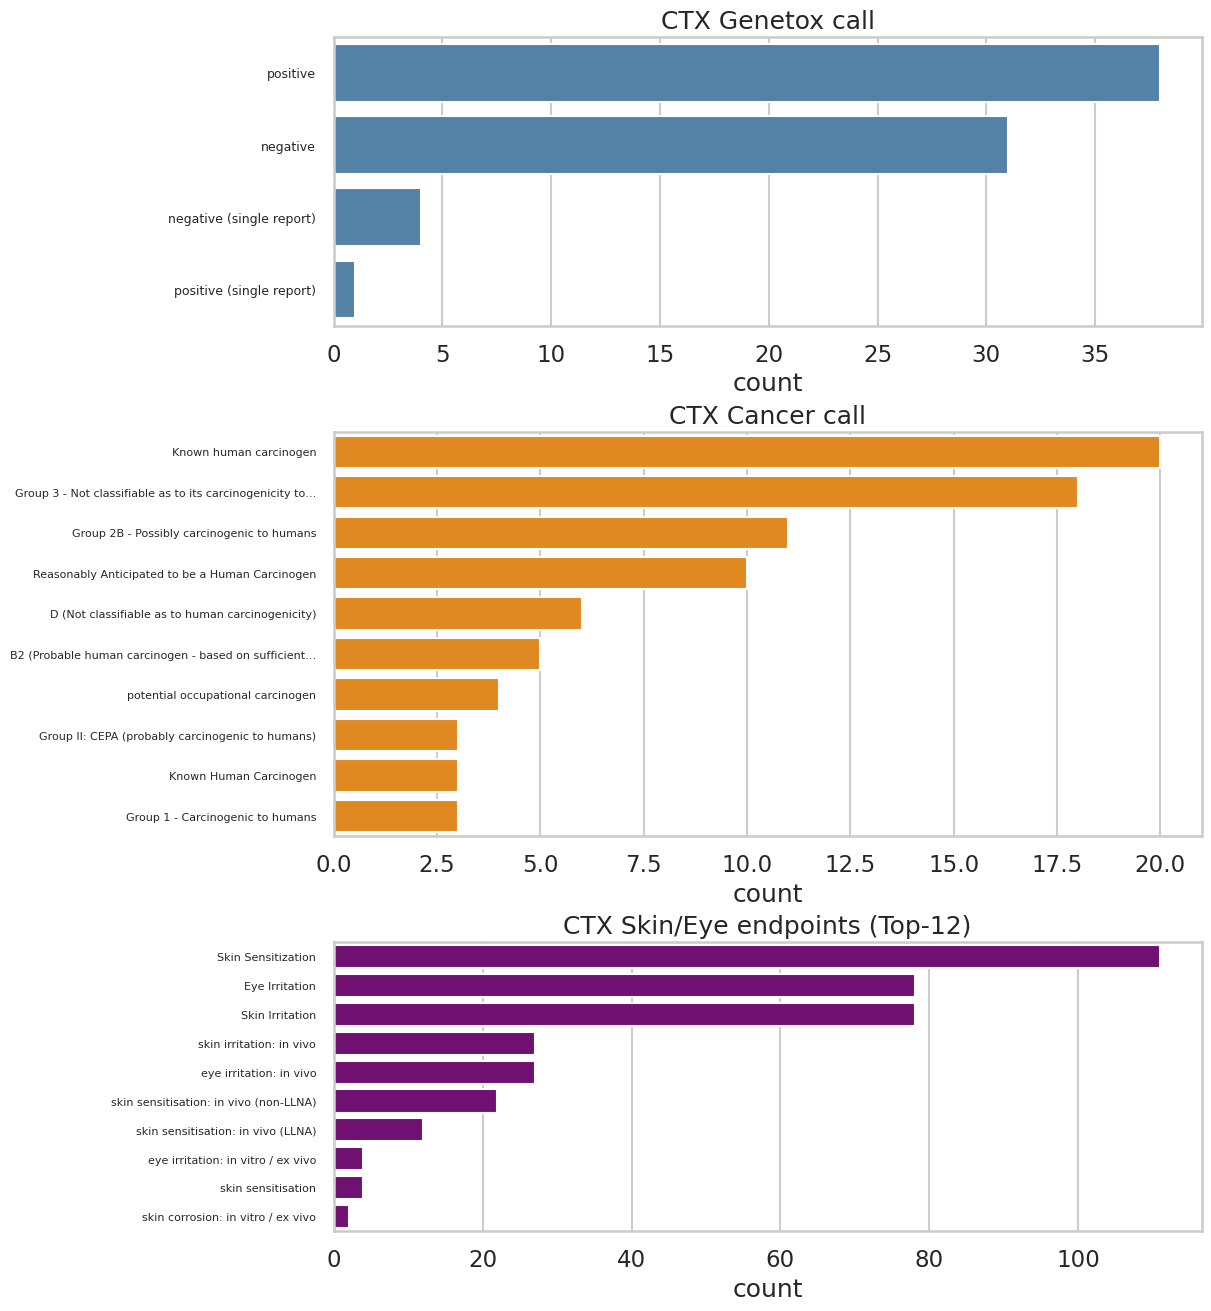

,preferred_name,toxicity_prior,hazard_prob,clintox_prob,adr_prob::Immune system disorders,ctx_genetox_call,ctx_cancer_call,ctx_reports_positive
0,"4,4'-(9H-Fluorene-9,9-diyl)diphenol",0.999994,0.962516,0.999670,0.496216,NaN,NaN,NaN
1,"N,N'-Di-2-naphthyl-p-phenylenediamine",0.999989,0.967374,0.999423,0.430966,positive,NaN,1.0
2,SSR161421,0.999988,0.881955,0.999749,0.585091,NaN,NaN,NaN
3,Telmisartan,0.999987,0.851955,0.999779,0.611891,NaN,NaN,NaN
4,Difethialone,0.999986,0.962871,0.999094,0.580108,NaN,NaN,NaN
5,4-(2-Phenylpropan-2-yl)-N-[4-(2-phenylpropan-2...,0.999982,0.941818,0.999413,0.483136,negative,NaN,0.0
6,Naphthalen-2-yl 2-aminobenzoate,0.999979,0.886100,0.999550,0.594513,NaN,NaN,NaN
7,Farglitazar,0.999978,0.919110,0.999209,0.650114,NaN,NaN,NaN
8,C.I. Solvent Red 24,0.999977,0.916136,0.999523,0.429924,negative,Group 3 - Not classifiable as to its carcinoge...,1.0
9,"Dibenz[a,c]anthracene",0.999971,0.903912,0.999515,0.381666,positive,Known human carcinogen,4.0


/tmp/ipykernel_491308/191854354.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_ctx2, x="ctx_genetox_positive", y="toxicity_prior", palette="Set2")


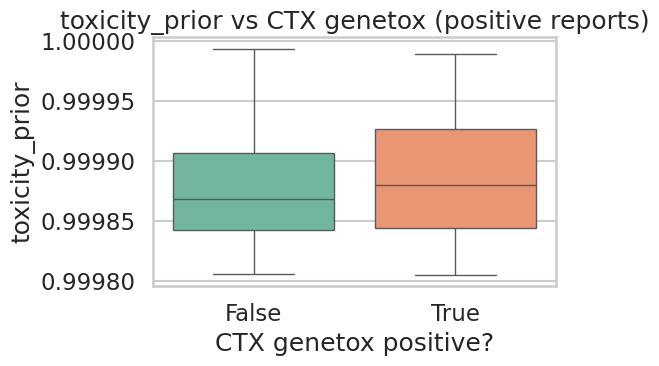

In [17]:
# 本单元格功能与目的（可选）：
# - 调用 US EPA 的 CTX Hazard API，为 `toxicity_prior` 排名前列的化合物拉取 genetox、cancer summary 与 skin/eye 等 hazard 摘要信息。
# - 将接口返回结果写入 `outputs/`，并对关键字段做简单汇总与可视化，用于与模型预测形成互补证据。
# - 将部分摘要特征回填到 Top 化合物表，方便后续统一查看与导出。

import os
from pathlib import Path

from jtm_risk.ctx import (
    CtxClient,
    ctx_hazard_cancer_summary_by_dtxsid_batch,
    ctx_hazard_genetox_summary_by_dtxsid_batch,
    ctx_hazard_skin_eye_by_dtxsid_batch,
)

def _maybe_set_env_from_dotenv(key: str, env_path: Path) -> None:
    if os.getenv(key):
        return
    if not env_path.exists():
        return
    for line in env_path.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if (not s) or s.startswith("#") or ("=" not in s):
            continue
        k, v = s.split("=", 1)
        if k.strip() != key:
            continue
        value = v.strip().strip("\"").strip("'")
        if value:
            os.environ[key] = value
        return

# Preferred: environment variable `CTX_API_KEY`.
# Local option: create `.env` under project root with a line `CTX_API_KEY=...`.
_env_root = globals().get("PROJECT_ROOT", Path.cwd())
_maybe_set_env_from_dotenv("CTX_API_KEY", Path(_env_root) / ".env")
CTX_API_KEY = (os.getenv("CTX_API_KEY") or "").strip()

if not CTX_API_KEY:
    print("CTX_API_KEY not set -> skip CTX Hazard API enrichment")
else:
    ctx = CtxClient(api_key=CTX_API_KEY)

    # 仅对 Top 化合物做 CTX 注释（避免调用量过大，可按需调大）
    top_ctx = chem2.sort_values("toxicity_prior", ascending=False).head(200).copy()
    dtxsids = top_ctx["dtxsid"].astype(str).tolist()

    genetox = ctx_hazard_genetox_summary_by_dtxsid_batch(ctx, dtxsids, cache_dir=CACHE_DIR)
    cancer = ctx_hazard_cancer_summary_by_dtxsid_batch(ctx, dtxsids, cache_dir=CACHE_DIR)
    skin_eye = ctx_hazard_skin_eye_by_dtxsid_batch(ctx, dtxsids, cache_dir=CACHE_DIR)

    genetox.to_csv(OUT_DIR / "ctx_genetox_summary.csv", index=False)
    cancer.to_csv(OUT_DIR / "ctx_cancer_summary.csv", index=False)
    skin_eye.to_csv(OUT_DIR / "ctx_skin_eye.csv", index=False)

    display(genetox.head(10))
    display(cancer.head(10))
    display(skin_eye.head(10))

    import textwrap

    fig, axes = plt.subplots(
        3,
        1,
        figsize=(12, 13),
        constrained_layout=True,
        gridspec_kw={"height_ratios": [1.0, 1.4, 1.0]},
    )

    def _shorten_yticks(ax, width: int, fontsize: int) -> None:
        labels = [t.get_text() for t in ax.get_yticklabels()]
        ax.set_yticklabels([textwrap.shorten(s, width=width, placeholder="…") for s in labels], fontsize=fontsize)
    if (not genetox.empty) and ("genetoxCall" in genetox.columns):
        order = genetox["genetoxCall"].astype(str).value_counts().index
        sns.countplot(data=genetox, y="genetoxCall", order=order, ax=axes[0], color="steelblue")
        axes[0].set_title("CTX Genetox call")
        axes[0].set_xlabel("count")
        axes[0].set_ylabel("")
        _shorten_yticks(axes[0], width=55, fontsize=9)
    else:
        axes[0].axis("off")

    if (not cancer.empty) and ("cancerCall" in cancer.columns):
        order = cancer["cancerCall"].astype(str).value_counts().head(10).index
        sub = cancer[cancer["cancerCall"].astype(str).isin(order)].copy()
        sns.countplot(data=sub, y="cancerCall", order=order, ax=axes[1], color="darkorange")
        axes[1].set_title("CTX Cancer call")
        axes[1].set_xlabel("count")
        axes[1].set_ylabel("")
        _shorten_yticks(axes[1], width=60, fontsize=8)
    else:
        axes[1].axis("off")

    if (not skin_eye.empty) and ("endpoint" in skin_eye.columns):
        order = skin_eye["endpoint"].astype(str).value_counts().head(12).index
        sns.countplot(data=skin_eye[skin_eye["endpoint"].astype(str).isin(order)], y="endpoint", order=order, ax=axes[2], color="purple")
        axes[2].set_title("CTX Skin/Eye endpoints (Top-12)")
        axes[2].set_xlabel("count")
        axes[2].set_ylabel("")
        _shorten_yticks(axes[2], width=55, fontsize=8)
    else:
        axes[2].axis("off")

    plt.show()

    # 将 genetox/cancer 的摘要特征回填到 top chemical 表，便于结果汇报与复核
    g_agg = (
        genetox.groupby("dtxsid", as_index=False)
        .agg(
            ctx_reports_positive=("reportsPositive", "max"),
            ctx_reports_negative=("reportsNegative", "max"),
            ctx_genetox_call=("genetoxCall", "first"),
        )
        if not genetox.empty and "dtxsid" in genetox.columns
        else pd.DataFrame(columns=["dtxsid","ctx_reports_positive","ctx_reports_negative","ctx_genetox_call"])
    )
    c_agg = (
        cancer.groupby("dtxsid", as_index=False)
        .agg(ctx_cancer_call=("cancerCall", "first"))
        if not cancer.empty and "dtxsid" in cancer.columns
        else pd.DataFrame(columns=["dtxsid","ctx_cancer_call"])
    )
    top_ctx2 = top_ctx.merge(g_agg, on="dtxsid", how="left").merge(c_agg, on="dtxsid", how="left")
    top_ctx2.to_csv(OUT_DIR / "chemicals_top200_with_ctx_hazard.csv", index=False)
    display(top_ctx2.head(20)[["preferred_name","toxicity_prior","hazard_prob","clintox_prob",immune_col,"ctx_genetox_call","ctx_cancer_call","ctx_reports_positive"]])

    # Plot: toxicity_prior vs CTX genetox positive reports
    if not top_ctx2.empty and "ctx_reports_positive" in top_ctx2.columns:
        top_ctx2["ctx_genetox_positive"] = top_ctx2["ctx_reports_positive"].fillna(0).astype(float) > 0
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=top_ctx2, x="ctx_genetox_positive", y="toxicity_prior", palette="Set2")
        plt.title("toxicity_prior vs CTX genetox (positive reports)")
        plt.xlabel("CTX genetox positive?")
        plt.ylabel("toxicity_prior")
        plt.tight_layout()
        plt.show()


## 11c) 靶点导向筛选：面向 S1PR1 的有害化合物候选

本单元格提供一个“靶点→化合物”的反向检索视角：固定目标靶点 S1PR1，针对所有输入化合物预测其与 S1PR1 的相互作用概率，并与化合物侧的 toxicity_prior 融合，得到靶点导向的风险筛选分数（`s1pr1_risk_score = toxicity_prior × interaction_prob`）。
该结果用于筛选潜在“高风险且可能作用于 S1PR1”的候选化合物，为后续实验验证、文献复核或风险评估提供优先级建议。


,rank,dtxsid,preferred_name,toxicity_prior,hazard_prob,clintox_prob,interaction_prob,s1pr1_risk_score,gene_symbol,uniprot_id
0,1,DTXSID8040270,Dithianon,0.991691,0.816280,0.879926,0.481331,0.477332,S1PR1,P21453
1,2,DTXSID8032548,"4-(4-Chlorophenyl)-2-phenyl-2-(1H-1,2,4-triazo...",0.999711,0.828625,0.997186,0.477255,0.477118,S1PR1,P21453
2,3,DTXSID2025422,alpha-Hydroxybenzeneacetonitrile,0.979047,0.316297,0.955085,0.486671,0.476474,S1PR1,P21453
3,4,DTXSID7040990,Carbonyl cyanide chlorophenylhydrazone,0.969418,0.512081,0.896446,0.489172,0.474212,S1PR1,P21453
4,5,DTXSID5023324,Milrinone,0.995415,0.406642,0.981110,0.475901,0.473719,S1PR1,P21453
5,6,DTXSID7045813,Olprinone hydrochloride,0.992306,0.463029,0.973414,0.477026,0.473356,S1PR1,P21453
6,7,DTXSID8020919,1-(1-Naphthyl)-2-thiourea,0.998446,0.846730,0.986319,0.473898,0.473161,S1PR1,P21453
7,8,DTXSID9021134,1-Phenyl-2-thiourea,0.991174,0.612659,0.971124,0.477286,0.473073,S1PR1,P21453
8,9,DTXSID8034324,Phoxim,0.988080,0.783607,0.917003,0.477497,0.471805,S1PR1,P21453
9,10,DTXSID6040662,Closantel,0.997713,0.858397,0.972102,0.471729,0.470650,S1PR1,P21453


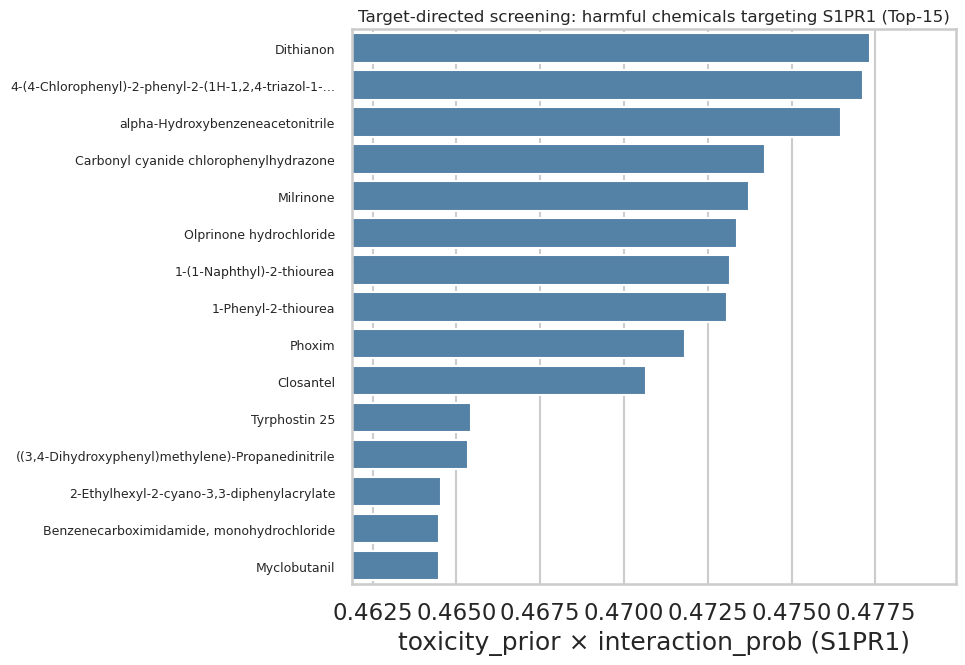

In [18]:
# 本单元格功能与目的：
# - 固定靶点 S1PR1，对所有输入化合物预测 DTI 作用概率，并与 toxicity_prior 融合形成靶点导向筛选分数。
# - 输出面向 S1PR1 的候选化合物全量排名表到 `outputs/screening_s1pr1_harmful_chemicals.csv`。
# - 给出基于 dtxsid 的检索方式，便于在全量结果中快速定位特定化合物。

TARGET_GENE = "S1PR1"

# Resolve target UniProt ID from the GeneCards table loaded earlier.
tgt = (
    genes[genes["gene_symbol"].astype(str).str.upper().eq(TARGET_GENE.upper())]
    .dropna(subset=["uniprot_id"])
    .copy()
)
if tgt.empty:
    raise ValueError(f"Target gene not found or missing UniProt ID: {TARGET_GENE}")
target_uniprot = str(tgt.iloc[0]["uniprot_id"]).strip()

# Resolve protein sequence (prefer cached `seqs`; fallback to cache file).
if (not isinstance(globals().get("seqs", None), dict)) or (target_uniprot not in seqs):
    from jtm_risk.external import uniprot_get_sequences
    seqs = uniprot_get_sequences([target_uniprot], cache_path=CACHE_DIR / "uniprot_sequences.csv")
target_seq = (seqs.get(target_uniprot) or "").strip()
if not target_seq:
    raise ValueError(f"Missing sequence for UniProt ID: {target_uniprot}")

# Load DTI model if not already in memory (e.g., when running cells out of order).
if "dti_model" not in globals():
    dti_model = joblib.load(MODEL_DIR / "dti_model.joblib")

# Score all chemicals with available SMILES against S1PR1.
chem_all = chem2.dropna(subset=["smiles"]).copy()
chem_all["smiles"] = chem_all["smiles"].astype(str)
smiles_all = chem_all["smiles"].tolist()

chunk = 2000
probs = []
for start in range(0, len(smiles_all), chunk):
    batch = smiles_all[start : start + chunk]
    probs.append(dti_model.predict_proba(batch, [target_seq] * len(batch)))
chem_all["interaction_prob"] = np.concatenate(probs) if probs else np.asarray([], dtype=float)

chem_all["s1pr1_risk_score"] = (
    pd.to_numeric(chem_all["toxicity_prior"], errors="coerce").fillna(0.0).astype(float)
    * pd.to_numeric(chem_all["interaction_prob"], errors="coerce").fillna(0.0).astype(float)
)
chem_all["gene_symbol"] = TARGET_GENE
chem_all["uniprot_id"] = target_uniprot

chem_all = chem_all.sort_values("s1pr1_risk_score", ascending=False, kind="mergesort").reset_index(drop=True)
chem_all.insert(0, "rank", np.arange(1, len(chem_all) + 1))

cols = [
    "rank",
    "dtxsid",
    "preferred_name",
    "toxicity_prior",
    "hazard_prob",
    "clintox_prob",
    "interaction_prob",
    "s1pr1_risk_score",
    "gene_symbol",
    "uniprot_id",
]
s1pr1_screen = chem_all.loc[:, [c for c in cols if c in chem_all.columns]].copy()
s1pr1_screen.to_csv(OUT_DIR / "screening_s1pr1_harmful_chemicals.csv", index=False)

display(s1pr1_screen.head(20))

# Plot Top-15 for quick review (x-axis is truncated to emphasize small differences).
import textwrap
top = s1pr1_screen.head(15).copy()
top["preferred_name_short"] = top["preferred_name"].astype(str).map(lambda s: textwrap.shorten(s, width=55, placeholder="…"))
plt.figure(figsize=(10, 7))
ax = sns.barplot(data=top, y="preferred_name_short", x="s1pr1_risk_score", color="steelblue")
ax.set_title("Target-directed screening: harmful chemicals targeting S1PR1 (Top-15)", fontsize=12)
ax.set_xlabel("toxicity_prior × interaction_prob (S1PR1)")
ax.set_ylabel("")
ax.tick_params(axis="y", labelsize=9)
x = pd.to_numeric(top["s1pr1_risk_score"], errors="coerce").dropna()
if not x.empty:
    xmin = float(x.min())
    xmax = float(x.max())
    rng = max(0.0, xmax - xmin)
    pad = max(rng * 0.20, 0.002)
    ax.set_xlim(xmin - pad, xmax + pad)
plt.tight_layout()
plt.show()

# Optional: locate a specific chemical by DTXSID (edit as needed).
lookup_dtxsid = None  # e.g., "DTXSID..."
if lookup_dtxsid:
    display(s1pr1_screen[s1pr1_screen["dtxsid"].astype(str) == str(lookup_dtxsid)].head(1))


## 12) 结果汇总（输出文件清单）

本单元格对全流程产出的关键结果文件进行汇总，便于后续复核、可视化展示与下游分析。以下文件默认保存到 `outputs/`：

- `chemicals_with_toxicity_priors.csv`：多源毒性先验（hazard + ClinTox + SIDER）
- `dti_dataset_from_chembl.csv`：DTI 监督数据
- `ranked_chemical_target_pairs_v2_network.csv`：最终候选对（含 `network_gene_score` 与融合网络项的综合得分）
- `screening_s1pr1_harmful_chemicals.csv`：面向 S1PR1 的靶点导向筛选结果（全量化合物排名）
- `network_scores_by_chemical.csv`：化合物对疾病模块的网络扰动得分
- `network_biomarkers_top20_per_chemical.csv`：候选机制/生物标志物基因
- `reactome_pathway_impact_top40_per_chemical.csv`：通路层解释（每个化合物 Top-40 通路）
- （可选，需 CTX）`ctx_genetox_summary.csv`、`ctx_cancer_summary.csv`、`ctx_skin_eye.csv`：CTX Hazard API 外部证据
- （可选，需 CTX）`chemicals_top200_with_ctx_hazard.csv`：Top 化合物合并 CTX hazard 摘要特征

定位特定化合物-靶点组合时，建议直接在 `ranked_chemical_target_pairs_v2_network.csv` 中按 `dtxsid` 与 `gene_symbol` 过滤；在 Notebook 中也可以使用如下检索方式：

```python
dtxsid = "DTXSID..."
gene_symbol = "GENE"
pairs_net.query("dtxsid == @dtxsid and gene_symbol == @gene_symbol")
```
